In [1]:
import os
from pathlib import Path
import math

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from dokdonia import visualization as VI
from dokdonia.utils import read_from_pickle_file

%matplotlib inline


root_dir = Path(os.getcwd()).parent
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Load datasets

In [2]:
TC = pd.read_csv(data_dir / "processed" / "DokdoniaMED134_TC.tsv", sep="\t").set_index("index")
# TC.index.name = None
deseq2_counts = pd.read_csv(data_dir / "processed" / "DokdoniaMED134_DS2.tsv", sep="\t").set_index("index")
DELD = read_from_pickle_file(results_dir / "deseq_results" / "DELD.pkl")

In [3]:
light_marker_genes = [
    ("MED134_07119", "proteorhodopsin"),
    ("MED134_14266", "deoxyribodipyrimidine photo-lyase class I"),
    ("MED134_10201", "cryptochrome of the DASH family"),
    ("MED134_13071", "phytoene synthase"),
    ("MED134_13076", "phytoene dehydrogenase"),
    ("MED134_13081", "transcription regulator, MerR family"),
    ("MED134_10206", "photolyase-related protein"),
    ("MED134_10211", "DNA photolyase/cryptochrome"),
    ("MED134_07089", "blue light sensor using FAD"),
]

dark_marker_genes = [
    ("MED134_06219", "two-component system sensor histidine kinase"),
]

plot_marker_genes = {
    "C0": [
        ("MED134_05219","TonB dependent/ligand-gated channel"),
        ("MED134_14141","isocitrate dehydrogenase"),
        ("MED134_09101", "superoxide dismutase"),
        ("MED134_12981", "DNA gyrase subunit B"),
        ("MED134_04754", "DNA topoisomerase IV, subunit A"),
        ("MED134_06494","DNA polymerase III subunit gamma/tau"),
        ("MED134_01190","gliding motility protein GldK"),
        ("MED134_12046","gliding motility protein GldJ"),
    ],
    "C1": [
        ("MED134_02950", "30S ribosomal protein S1"),
        ("MED134_02405", "50S ribosomal protein L1"),
        ("MED134_12576", "citrate synthase"),
        ("MED134_07711", "2-oxoglutarate dehydrogenase E1 component"),
        ("MED134_14156", "prolyl-tRNA synthetase"),
        ("MED134_11636", "alanyl-tRNA synthetase"),
        ("MED134_05054", "DEAD/DEAH box helicase"),
        ("MED134_14341", "DEAD/DEAH box helicase"),
        ("MED134_14381", "DEAD/DEAH box helicase"),
        ("MED134_10855", "cold shock domain protein CspD"),
        ("MED134_08066", "glutamine-fructose-6-phosphate transaminase (isomerizing)"),
        ("MED134_05784", "cold shock domain protein CspD"),
    
    ],
    "C2": [
        ("MED134_04199", "DNA polymerase III, beta subunit"),
        ("MED134_08006", "biotin synthase"),
        ("MED134_01135", "TCP-1/cpn60 chaperonin protein family"),
        ("MED134_02620", "universal stress protein UspA"),
        ("MED134_02690", "universal stress protein UspA"),
        ("MED134_05259", "RNA polymerase sigma factor, sigma-70 family"),
        ("MED134_05579", "malate dehydrogenase (quinone)"),
        ("MED134_01780", "isocitrate lyase"),
        ("MED134_06589", "serine hydroxymethyltransferase"),
    ],
    "C3": [
        ("MED134_11471", "periplasmic protein TonB"),
        ("MED134_01520", "acetyl-CoA carboxylase carboxyl transferase subunit alpha"),
        ("MED134_03030", "zinc carboxypeptidase"),
        ("MED134_13906", "metal-dependent amidohydrolase"),
        ("MED134_05959", "glycosyl transferase group 1"),
    ],
}

## Plot Deseq2 and TC values for some example genes

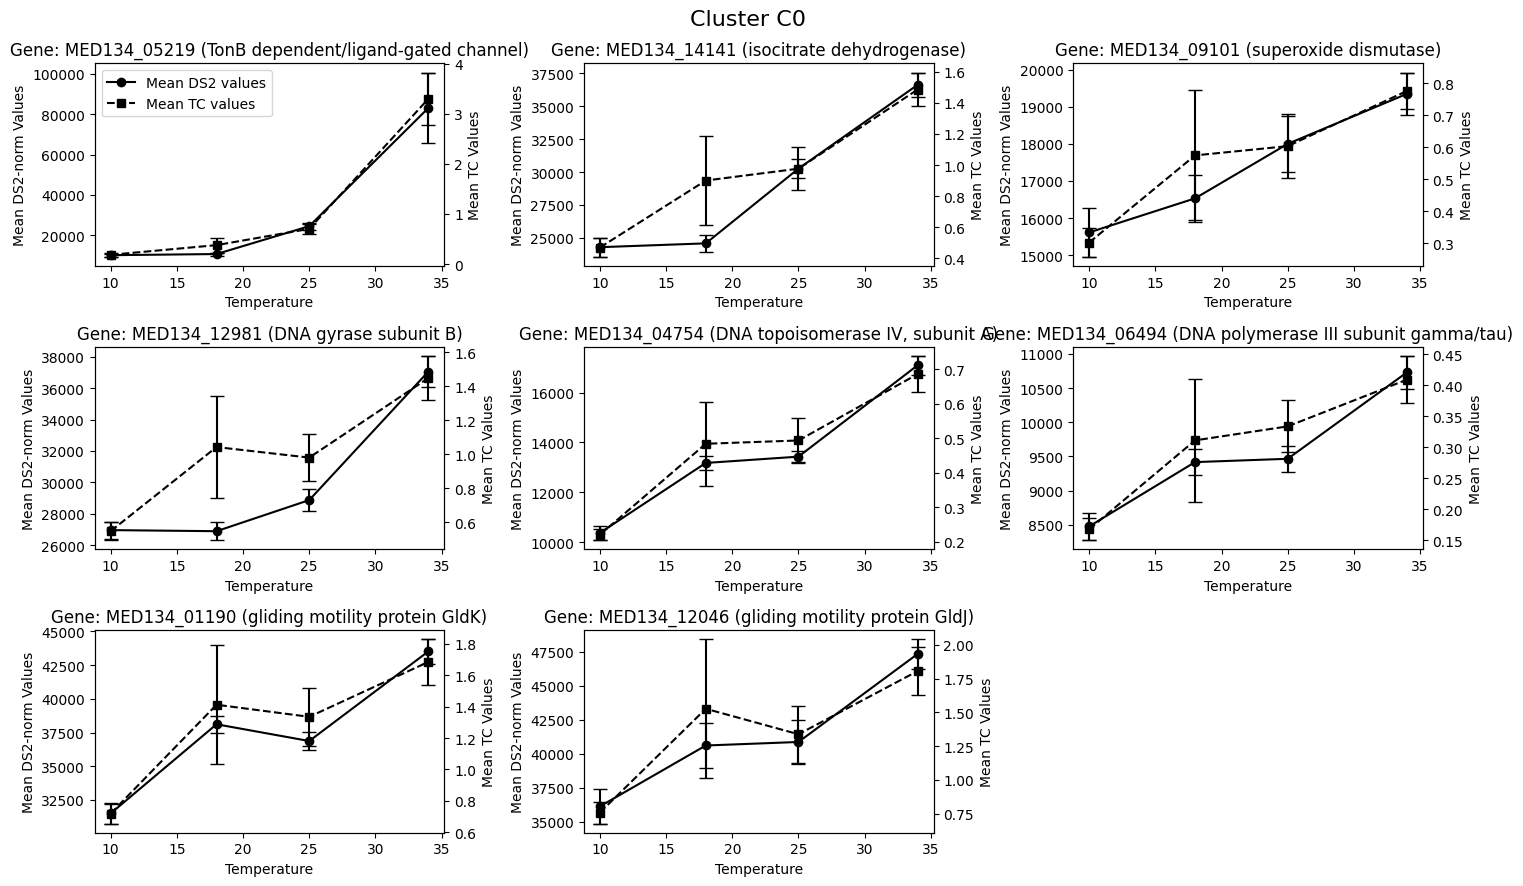

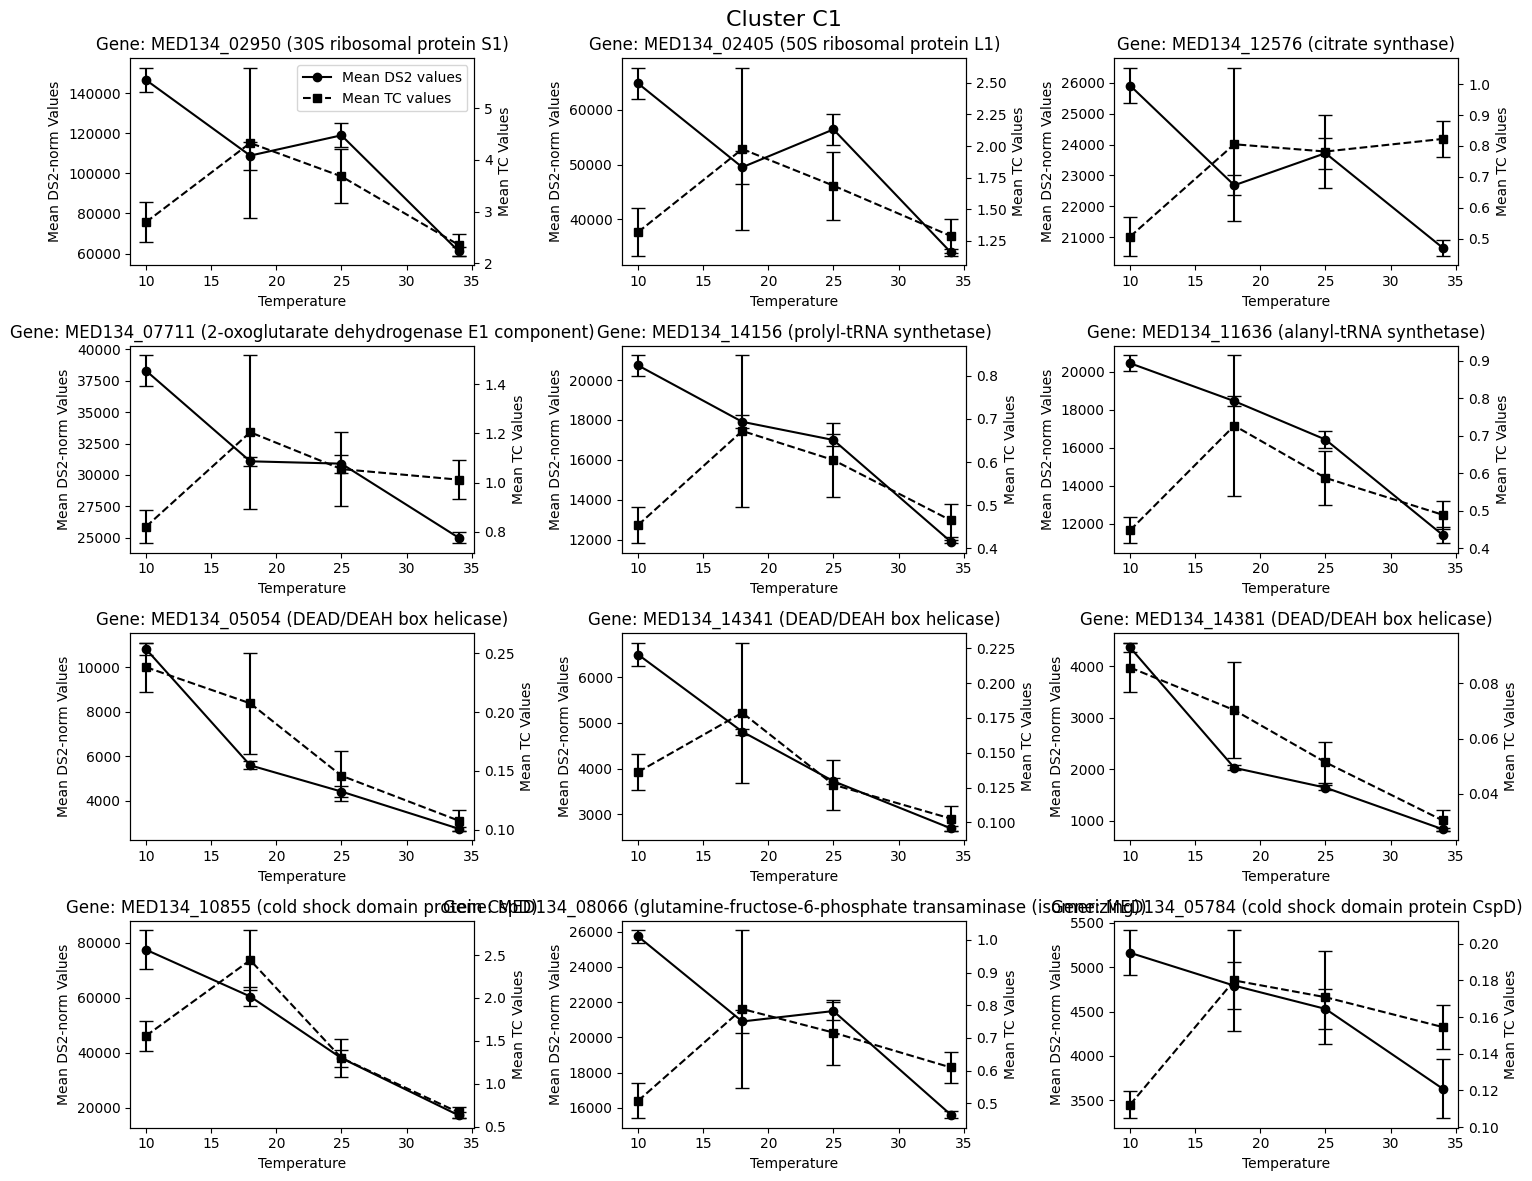

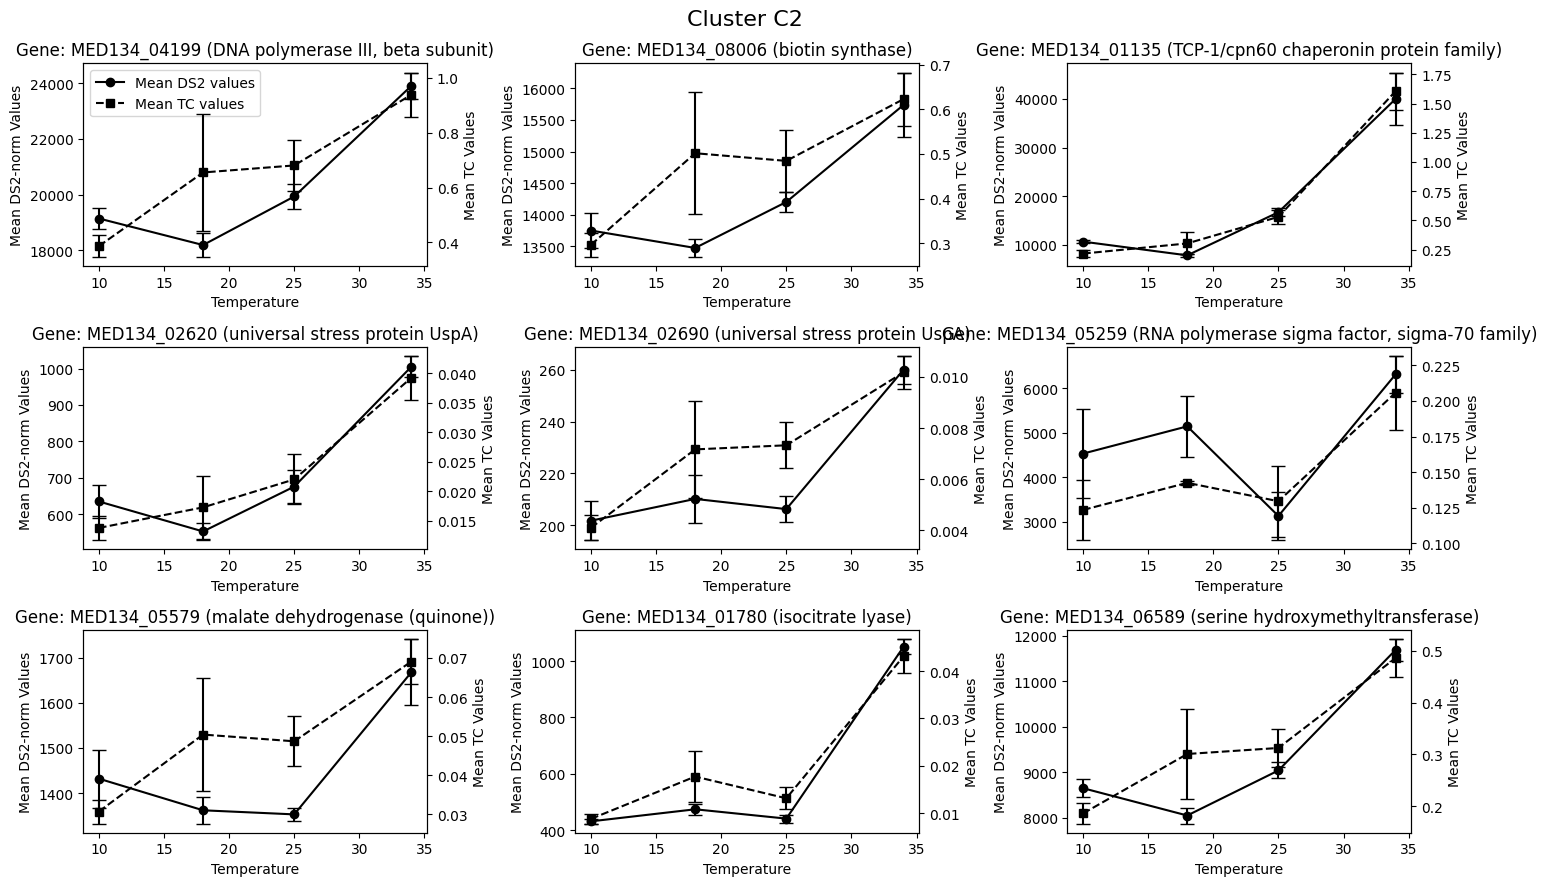

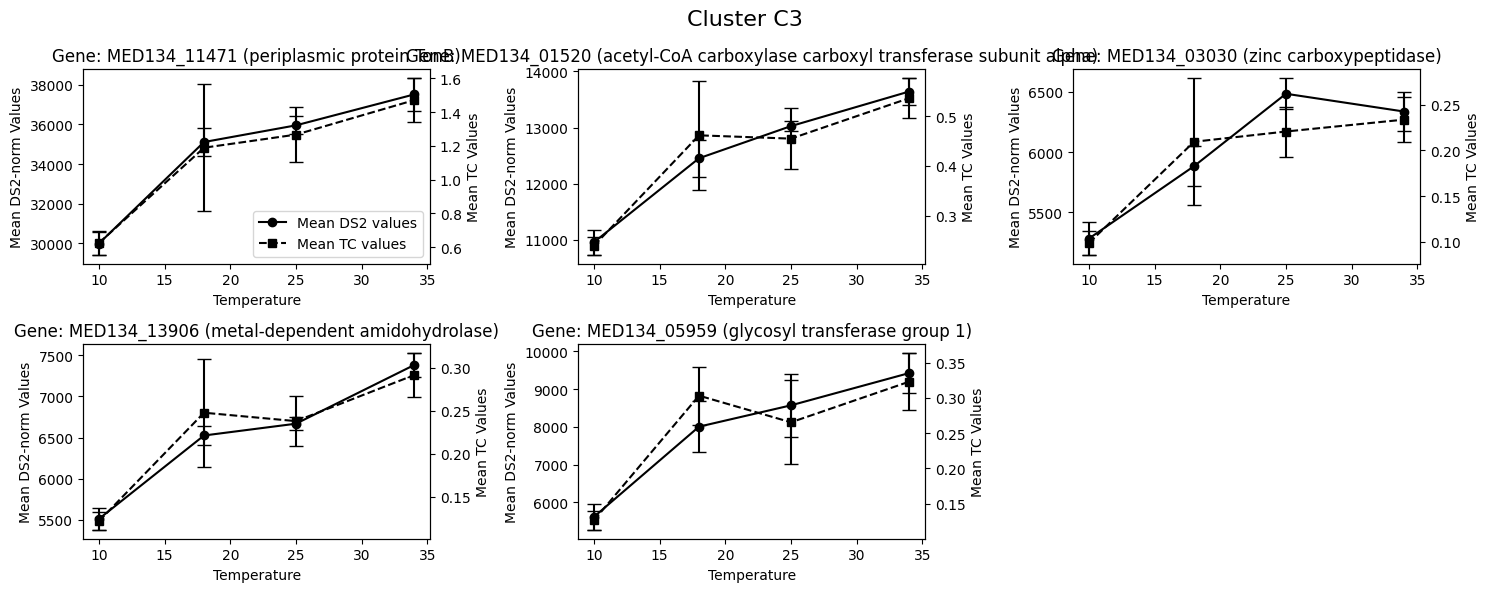

In [4]:
def plot_gene_expression(ax, gene_id, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    l1 = ax.plot(mean_values['Temperature'], mean_values['Value'], marker='o', linestyle='-', label='Mean DS2 values', color="k")
    ax.errorbar(mean_values['Temperature'], mean_values['Value'], yerr=standard_error_values['Value'], linestyle='', capsize=5, label='SDE DS2 values', color="k")
    ax2 = ax.twinx()
    l2 = ax2.plot(mean_values_TC['Temperature'], mean_values_TC['Value'], marker='s', linestyle='--', color='k', label='Mean TC values')
    ax2.errorbar(mean_values_TC['Temperature'], mean_values_TC['Value'], yerr=standard_error_values_TC['Value'], linestyle='', capsize=5, color='k', label='SDE TC values')

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Mean DS2-norm Values')
    ax2.set_ylabel('Mean TC Values')
    ax.set_title(f'Gene: {gene_id} ({gene_name})')
    if show_legend:
        legend_handles = l1 + l2
        legend_labels = [h.get_label() for h in legend_handles]
        ax.legend(legend_handles, legend_labels)

# Code for preprocessing the primary and secondary datasets
# Replace "TC" with the name of your second dataset
marker_genes = plot_marker_genes
target_genes = [gene[0] for cluster in marker_genes.values() for gene in cluster]

# Preprocess the primary dataset (deseq2_counts_noDE)
df_long = deseq2_counts.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

# Calculate mean and standard error values for the primary dataset (deseq2_counts_noDE)
grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the secondary dataset (TC)
TC_long = TC.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])

# Calculate mean and standard error values for the secondary dataset (TC)
grouped_TC = TC_long.groupby(['index', 'Temperature'])['Value']
mean_values_TC = grouped_TC.median().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()

for cluster, genes in marker_genes.items():
    # Plotting
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(f'Cluster {cluster}', fontsize=16)
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        mean_values_gene = mean_values[mean_values['index'] == gene_id]
        standard_error_values_gene = standard_error_values[standard_error_values['index'] == gene_id]
        mean_values_gene_TC = mean_values_TC[mean_values_TC['index'] == gene_id]
        standard_error_values_gene_TC = standard_error_values_TC[standard_error_values_TC['index'] == gene_id]
        show_legend = (idx == 0)
        plot_gene_expression(axs[idx], gene_id, gene_name, mean_values_gene, standard_error_values_gene, mean_values_gene_TC, standard_error_values_gene_TC, show_legend)

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.savefig(root_dir / f'paper_figures/cluster_{cluster}_gene_expression_temperature.png')
    plt.show()

In [5]:
functional_marker_genes = {
    "core_functions": [
        ("MED134_12981", "DNA gyrase subunit B"), # DNA replication
        ("MED134_04754", "DNA topoisomerase IV subunit A"),
        ("MED134_06494", "DNA polymerase III subunit gamma/tau"),
        ("MED134_04199", "DNA polymerase III, beta subunit"),
        ("MED134_00555", "DNA-directed DNA polymerase"),
        ("MED134_12541", "DNA-directed RNA polymerase, alpha subunit"), # Transcription
        ("MED134_02425", "DNA-directed RNA polymerase beta' chain"),
        ("MED134_02420", "DNA-directed RNA polymerase beta chain"),
        ("MED134_02110", "DNA-directed RNA polymerase, omega subunit"),
        ("MED134_05259", "RNA polymerase sigma factor"),
        ("MED134_02950", "30S ribosomal protein S1"), # Translation
        ("MED134_02405", "50S ribosomal protein L1"),
        ("MED134_14156", "prolyl-tRNA synthetase"),
        ("MED134_11636", "alanyl-tRNA synthetase"),
        ("MED134_06589", "serine hydroxymethyltransferase"), # Protein synthesis
        ("MED134_02820", "dihydrolipoyl dehydrogenase"),
        ("MED134_03484", "glutamate-ammonia ligase"),
        ("MED134_04069", "carbamoyl-phosphate synthase, large subunit"),
    ],
    "transport_gliding": [
        ("MED134_05219", "TonB dependent/ligand-gated channel"), # Transport and gliding motility
        ("MED134_04329", "TonB dependent/ligand-gated channel"),
        ("MED134_10161", "TonB dependent/ligand-gated channel"),
        ("MED134_04204", "gliding motility protein GldG"),
        ("MED134_01665", "gliding motility protein GldA"),
        ("MED134_08866", "gliding motility protein GldL"),
    ],
    "stress_response": [
        ("MED134_09101", "superoxide dismutase"), # Stress response
        ("MED134_02620", "universal stress protein UspA"),
        ("MED134_01135", "TCP-1/cpn60 chaperonin family protein"),
        ("MED134_05054", "DEAD/DEAH box helicase"),
        ("MED134_14341", "DEAD/DEAH box helicase"),
        ("MED134_14381", "DEAD/DEAH box helicase"),
        ("MED134_10855", "cold shock domain protein CspD"),
        ("MED134_05514", "cold shock domain protein CspD"),
        ("MED134_05784", "cold shock domain protein CspD"),
        ("MED134_05814", "chaperone protein DnaJ")
    ],
    "tca_glyoxylate": [
        ("MED134_11155", "succinate dehydrogenase flavoprotein subunit"), # TCA cycle + glyoxylate shunt
        ("MED134_07711", "2-oxoglutarate dehydrogenase E1 component"),
        ("MED134_13701", "succinyl-CoA synthetase, beta subunit"),
        ("MED134_05579", "malate dehydrogenase (quinone)"),
        ("MED134_12576", "citrate synthase"),
        ("MED134_01780", "isocitrate lyase"),
        ("MED134_01775", "malate synthase"),
    ],
    "cluster_IV": [
        ("MED134_03484", "glutamate-ammonia ligase"), # # Alanine, aspartate and glutamate metabolism
        ("MED134_12616", "aminotransferase class I and II"),
        ("MED134_11946", "argininosuccinate lyase"), # Arginine Biosynthesis
        ("MED134_11926", "acetylornithine aminotransferase"), # Biosynthesis of other secondary metabolites
        ("MED134_04314", "bifunctional aspartokinase/homoserine dehydrogenase 1")
    ], 
    "additional_genes": [
        ("MED134_03030", "zinc carboxypeptidase"),
        ("MED134_03169", "Na+/H+ antiporter NhaC"),
        ("MED134_13906", "metal-dependent amidohydrolase"),
        ("MED134_05959", "glycosyl transferases group 1"),
        ("MED134_11471", "periplasmic protein TonB"),
        ("MED134_01520", "acetyl-CoA carboxylase carboxyl transferase subunit alpha"),
    ]
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


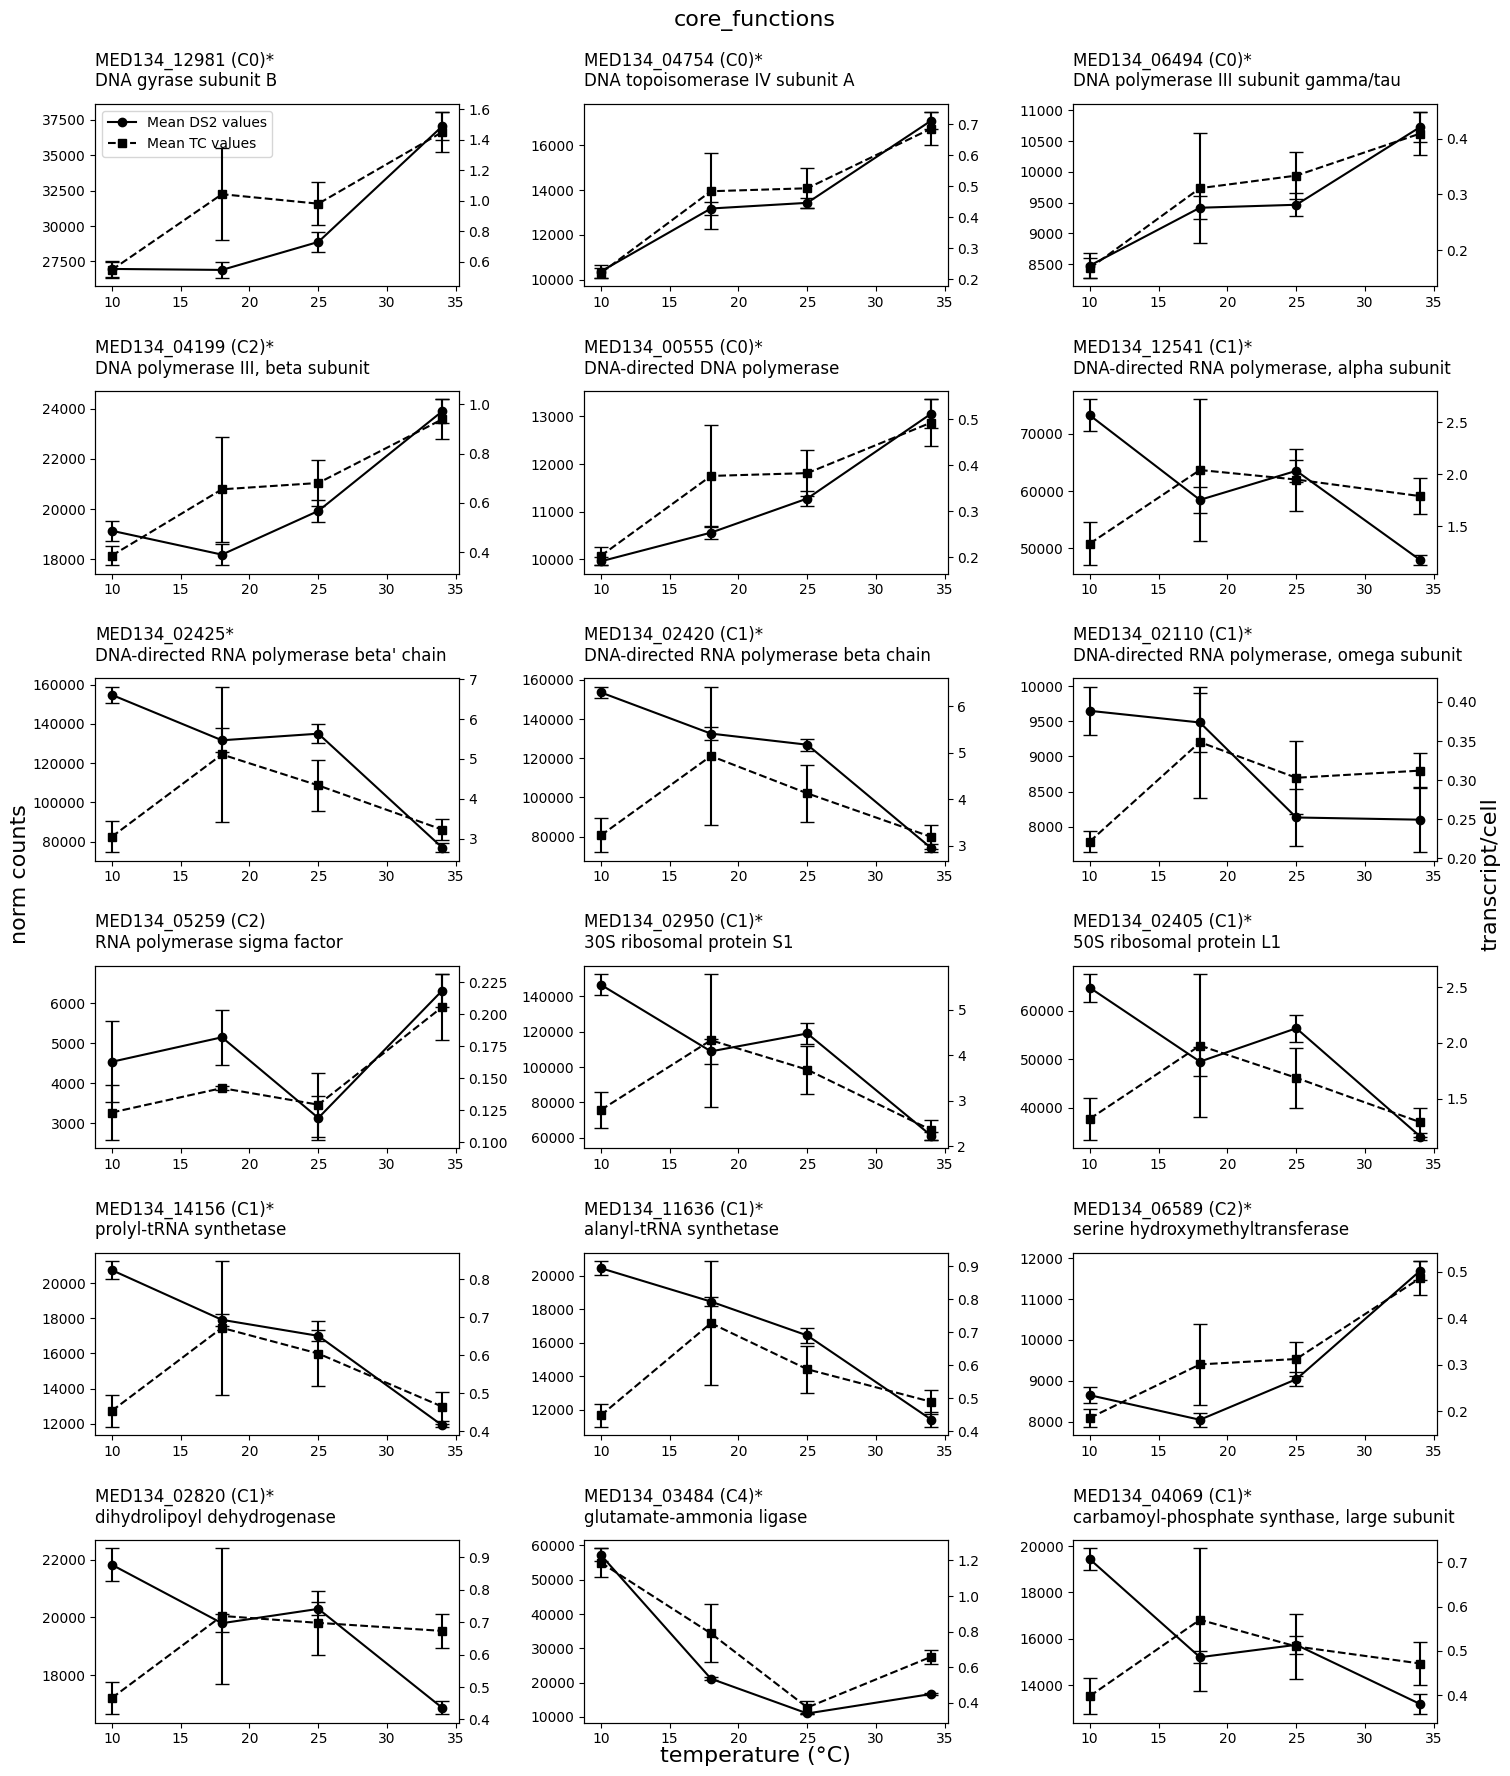

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


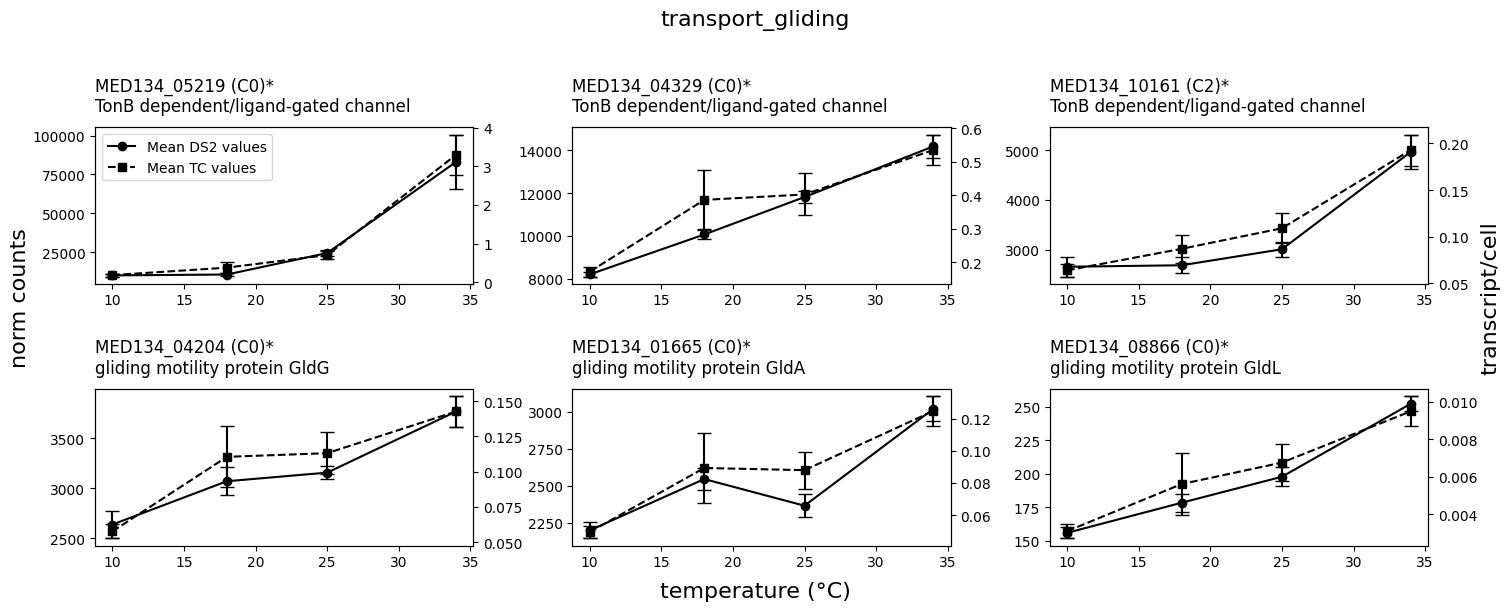

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


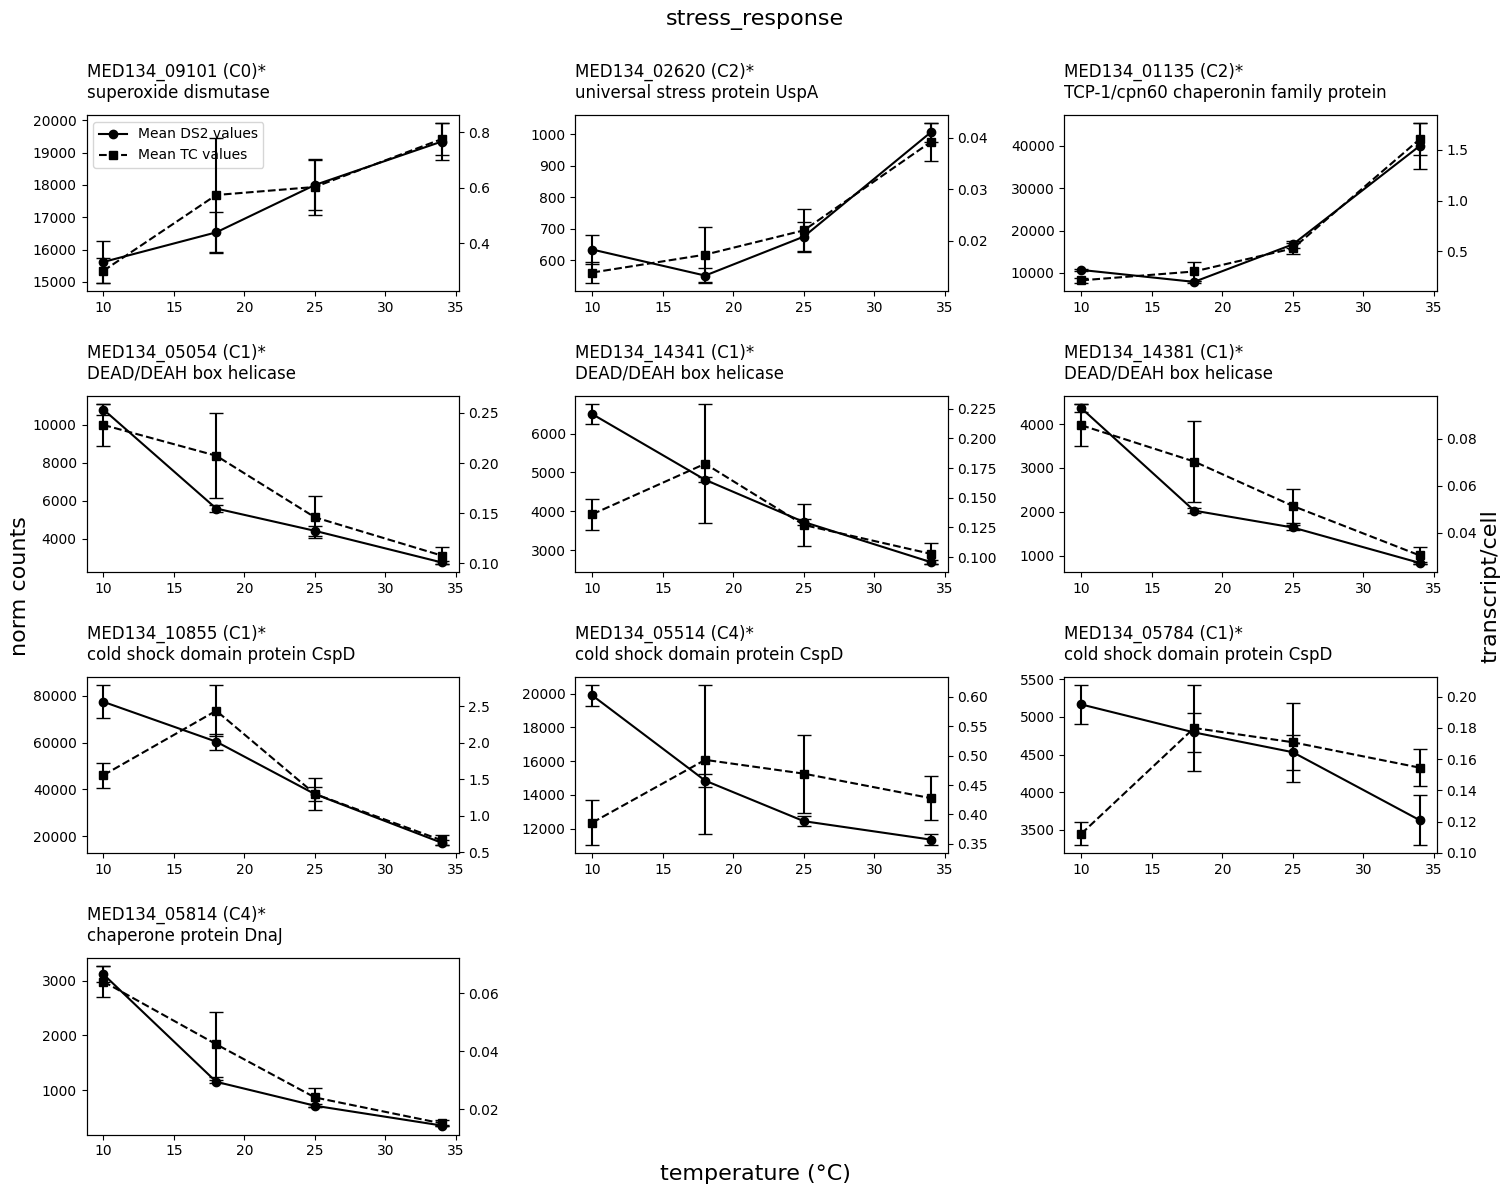

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


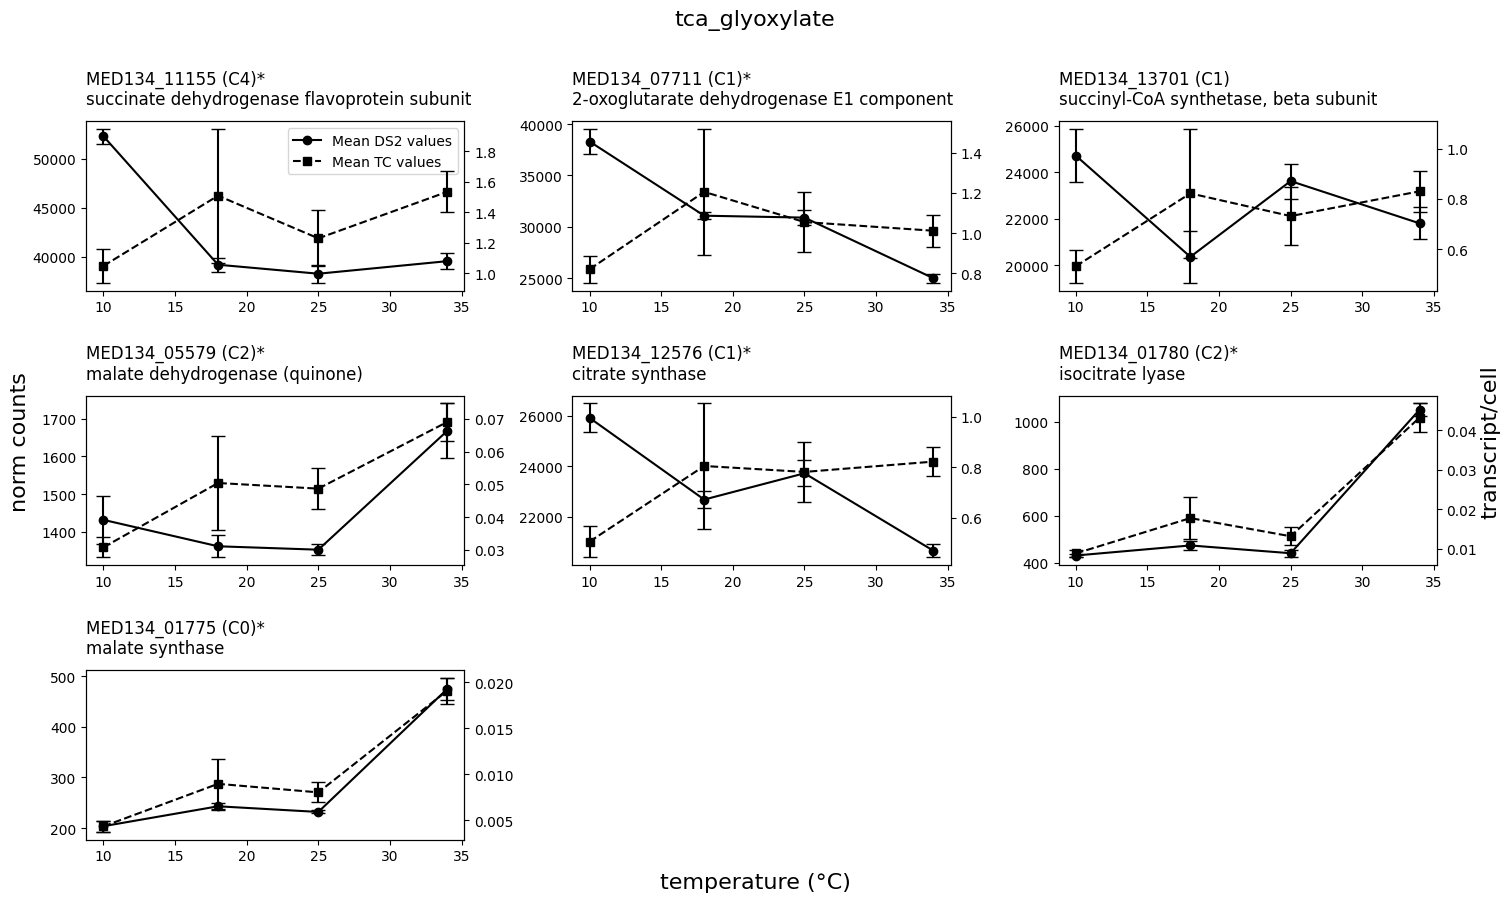

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


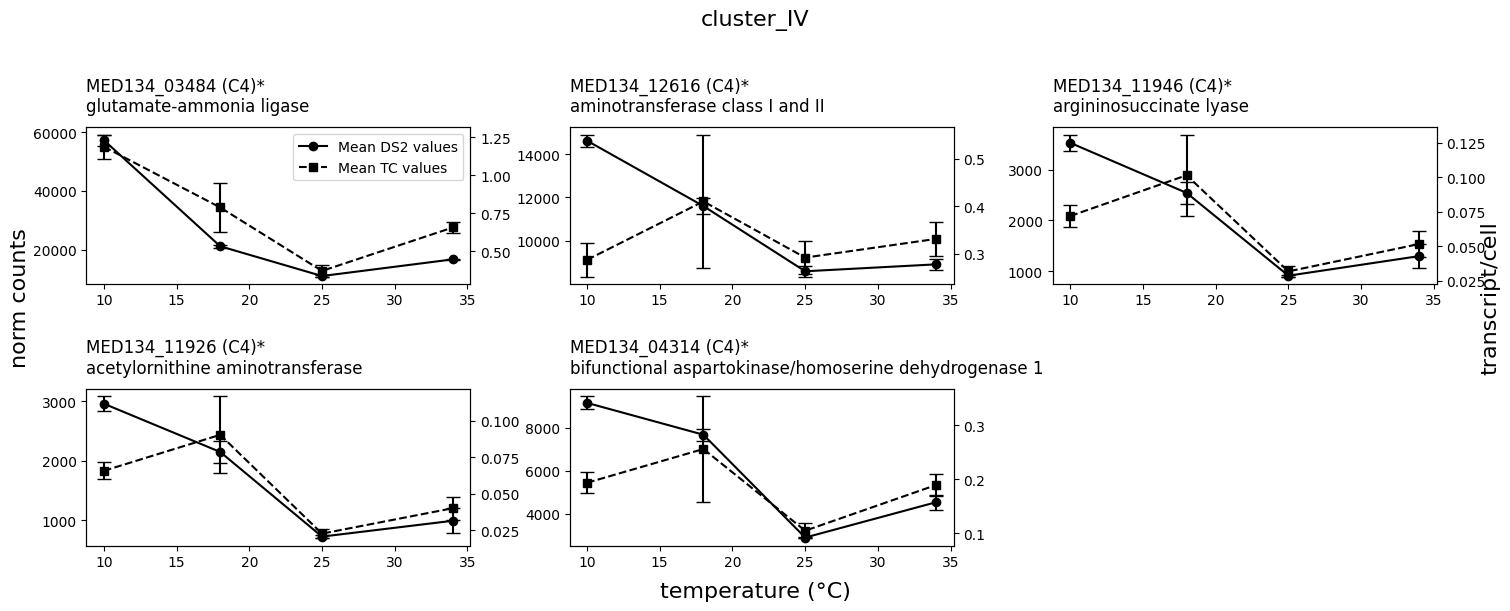

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


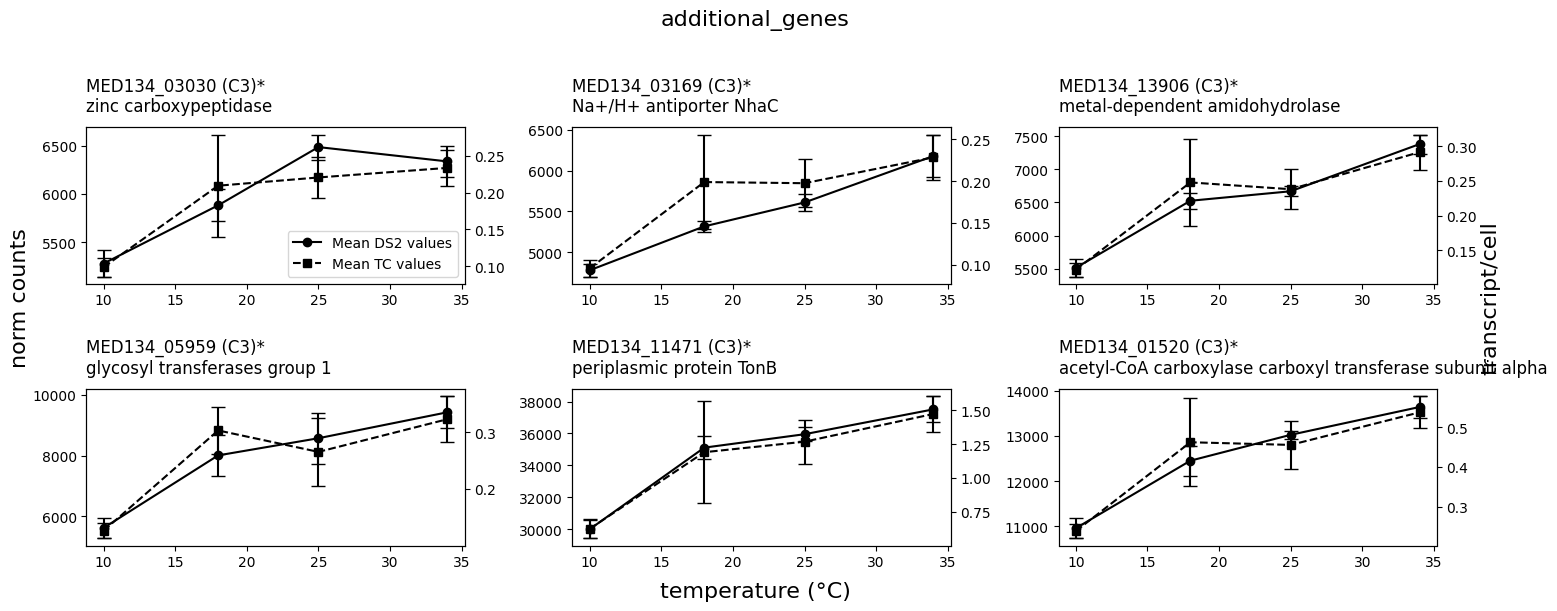

In [6]:
# Make directory for figures
(root_dir / "paper_figures/figure_4").mkdir(parents=True, exist_ok=True)


def add_cluster_to_locus_id(ranked_clusters: pd.DataFrame, locus_id: str) -> str:
    if locus_id in ranked_clusters.index:
        return ranked_clusters.loc[locus_id, "cluster"]
    else:
        return ""
    
def gene_id_DE_across_temperature(gene_id, deseq2_results, alpha=0.01):
    deseq2_results = deseq2_results[deseq2_results.padj <= alpha]
    return gene_id in deseq2_results.index

def plot_gene_expression(ax, gene_id, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    l1 = ax.plot(mean_values['Temperature'], mean_values['Value'], marker='o', linestyle='-', label='Mean DS2 values', color="k")
    ax.errorbar(mean_values['Temperature'], mean_values['Value'], yerr=standard_error_values['Value'], linestyle='', capsize=5, label='SDE DS2 values', color="k")
    ax2 = ax.twinx()
    l2 = ax2.plot(mean_values_TC['Temperature'], mean_values_TC['Value'], marker='s', linestyle='--', color='k', label='Mean TC values')
    ax2.errorbar(mean_values_TC['Temperature'], mean_values_TC['Value'], yerr=standard_error_values_TC['Value'], linestyle='', capsize=5, color='k', label='SDE TC values')

    # ax.set_xlabel('Temperature')
    # ax.set_ylabel('Mean DS2-norm Values')
    # ax2.set_ylabel('Mean TC Values')
    # ax.set_title(f'Gene: {gene_id} ({gene_name})')
    ax.set_title(f'{gene_id}\n{gene_name}', fontsize=12, loc='left', y=1.05)
    if show_legend:
        legend_handles = l1 + l2
        legend_labels = [h.get_label() for h in legend_handles]
        ax.legend(legend_handles, legend_labels)

ranked_clusters = pd.read_csv(results_dir / "pathways/ranked_clusters.csv", index_col=0)
deseq2_results = pd.read_excel(results_dir / "deseq_results/across_temperature_deseq2.xlsx").set_index("gene_id")

# Code for preprocessing the primary and secondary datasets
# Replace "TC" with the name of your second dataset
marker_genes = functional_marker_genes
target_genes = [gene[0] for cluster in marker_genes.values() for gene in cluster]

# Preprocess the primary dataset (deseq2_counts_noDE)
df_long = deseq2_counts.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

# Calculate mean and standard error values for the primary dataset (deseq2_counts_noDE)
grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the secondary dataset (TC)
TC_long = TC.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])

# Calculate mean and standard error values for the secondary dataset (TC)
grouped_TC = TC_long.groupby(['index', 'Temperature'])['Value']
mean_values_TC = grouped_TC.median().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()

for cluster, genes in marker_genes.items():
    # Plotting
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(f'{cluster}', fontsize=16)
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
    
        mean_values_gene = mean_values[mean_values['index'] == gene_id]
        standard_error_values_gene = standard_error_values[standard_error_values['index'] == gene_id]
        mean_values_gene_TC = mean_values_TC[mean_values_TC['index'] == gene_id]
        standard_error_values_gene_TC = standard_error_values_TC[standard_error_values_TC['index'] == gene_id]
        show_legend = (idx == 0)
        
        gene_cluster = add_cluster_to_locus_id(ranked_clusters, gene_id)
        gene_id_str = f'{gene_id} ({gene_cluster})' if gene_cluster else gene_id
        gene_id_str = f'{gene_id_str}*' if gene_id_DE_across_temperature(gene_id, deseq2_results) else gene_id_str
                
        plot_gene_expression(axs[idx], gene_id_str, gene_name, mean_values_gene, standard_error_values_gene, mean_values_gene_TC, standard_error_values_gene_TC, show_legend)

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    fig.text(0.5, 0.01, 'temperature (°C)', ha='center', va='center', fontsize=16)  # x-axis label
    fig.text(0.01, 0.5, 'norm counts', ha='center', va='center', rotation='vertical', fontsize=16)  # y-axis label
    fig.text(0.99, 0.5, 'transcript/cell', ha='center', va='center', rotation='vertical', fontsize=16) 


    # plt.tight_layout()
    plt.tight_layout(pad=2, w_pad=1)
    plt.savefig(root_dir / f'paper_figures/figure_4/cluster_{cluster}_gene_expression_temperature.png')
    plt.savefig(root_dir / f'paper_figures/figure_4/cluster_{cluster}_gene_expression_temperature.eps', dpi=300)
    plt.show()

## Plot genes for metabolic network figure


Hecho asi muy rápido a lo cutre pera para darte una idea, usando el mismo código de colores que tienes, podríamos mostrar el TCA cycle (+ la parte azul, roja y verde) de forma que en las enzimas ponemos el softcluster al que pertenecen (del Deseq) y abajo unos ejemplos de genes individuales? Me parece muy chulo que el glyoxylate shunt se active claramente cuando están estresadas por temperatura (se te ocurre por que?) Y faltaría ver que repuesta tiene la anaplerotic fixation, que tambien es relevante!


Además, falta añadir estos genes a la Figure 5:

* Fumarate hydratase MED134_07134

In [7]:
import pandas as pd


pathway_fig_marker_genes = {}

df = pd.read_csv(root_dir / "results/pathways/ranked_clusters.csv")
tca = df[df.subsystem.str.contains("TCA")]
pathway_fig_marker_genes["TCA"] = [(row.gene_id, f"{row.product}") for row in tca.itertuples()]
pathway_fig_marker_genes["TCA"].append(("MED134_07134", "fumarate hydratase")) # Not in clusters

glyo = df[df.subsystem.str.contains("Glyoxylate and dicarboxylate metabolism")]
pathway_fig_marker_genes["glyoxylate_shunt"] = [(row.gene_id, f"{row.product}") for row in glyo.itertuples()]

pathway_fig_marker_genes["anaplerotic_co2"] = [
    ("MED134_14627", "alpha-acetolactate decarboxylase"),
    ("MED134_07946", "acetate-CoA ligase"),
]

pathway_fig_marker_genes["glyoxylate_shunt"][-4] = ("MED134_10620", "4-hydroxy-2-oxoglutarate aldolase")

pathway_fig_marker_genes["pyruvate_metabolism"] = [
    ("MED134_06244", "pyruvate carboxylase"),
    ("MED134_06089", "phosphoenolpyruvate carboxylase"),
    ("MED134_10331", "phosphoenolpyruvate carboxykinase (ATP)"),
    ("MED134_11446", "NADP-dependent malate dehydrogenase")
]
pathway_fig_marker_genes

{'TCA': [('MED134_11155', 'succinate dehydrogenase flavoprotein subunit'),
  ('MED134_07711', '2-oxoglutarate dehydrogenase E1 component'),
  ('MED134_14141', 'isocitrate dehydrogenase'),
  ('MED134_12576', 'citrate synthase'),
  ('MED134_13701', 'succinyl-CoA synthetase, beta subunit'),
  ('MED134_02820', 'dihydrolipoyl dehydrogenase'),
  ('MED134_05579', 'malate dehydrogenase (quinone)'),
  ('MED134_07134', 'fumarate hydratase')],
 'glyoxylate_shunt': [('MED134_12576', 'citrate synthase'),
  ('MED134_02820', 'dihydrolipoyl dehydrogenase'),
  ('MED134_03484', 'glutamate-ammonia ligase'),
  ('MED134_06589', 'serine hydroxymethyltransferase'),
  ('MED134_07299', 'aminomethyltransferase'),
  ('MED134_03489', 'glutamate-ammonia ligase'),
  ('MED134_07946', 'acetate-CoA ligase'),
  ('MED134_10620', '4-hydroxy-2-oxoglutarate aldolase'),
  ('MED134_01780', 'isocitrate lyase'),
  ('MED134_01785', 'aminotransferase class-V'),
  ('MED134_01775', 'malate synthase')],
 'anaplerotic_co2': [('MED13

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


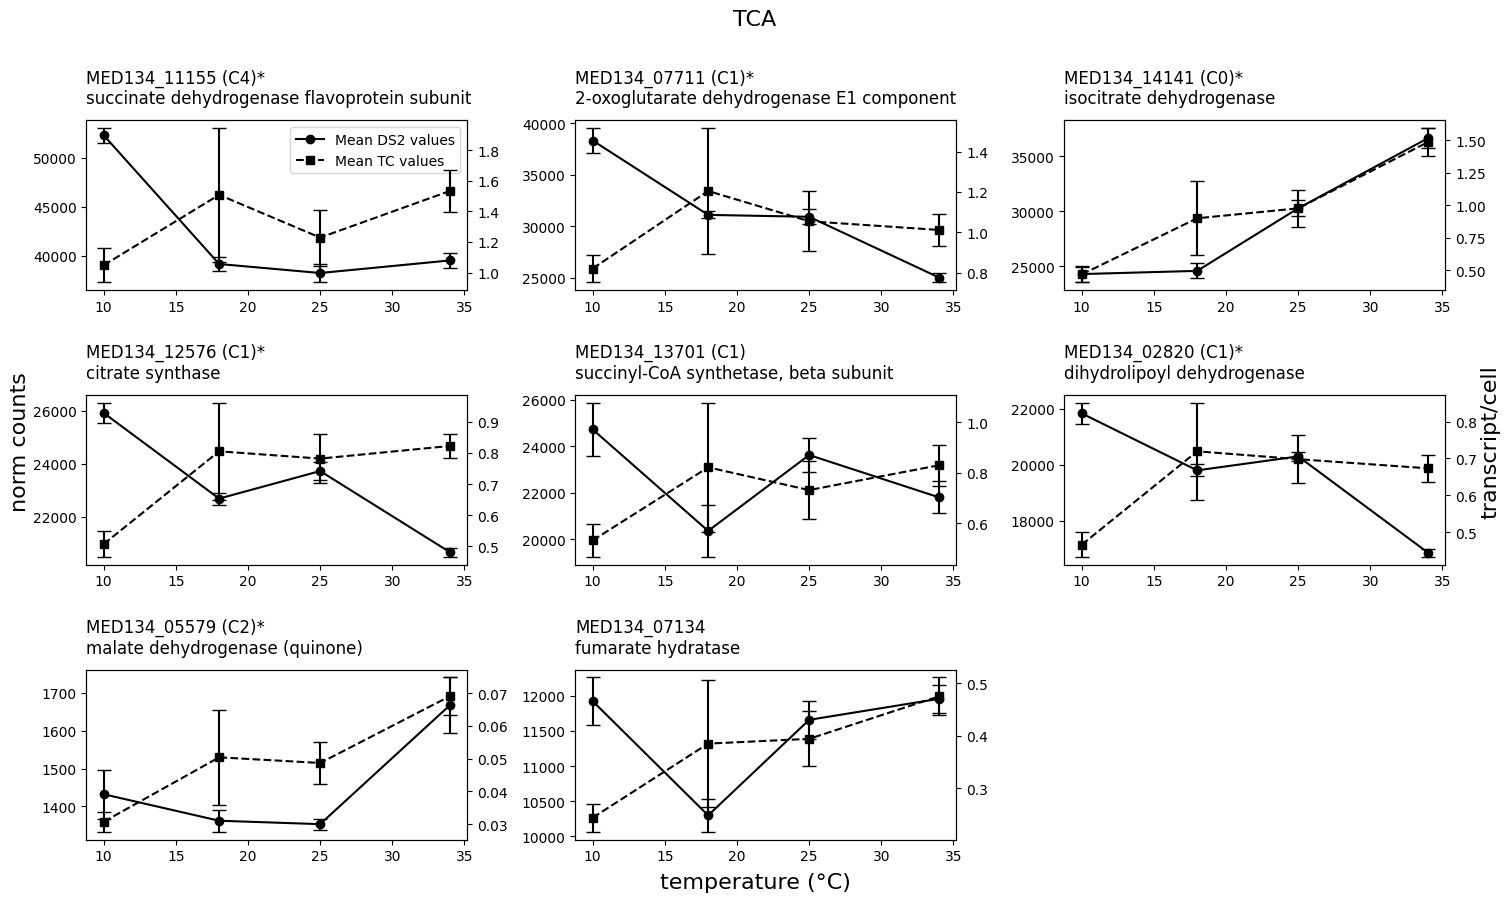

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


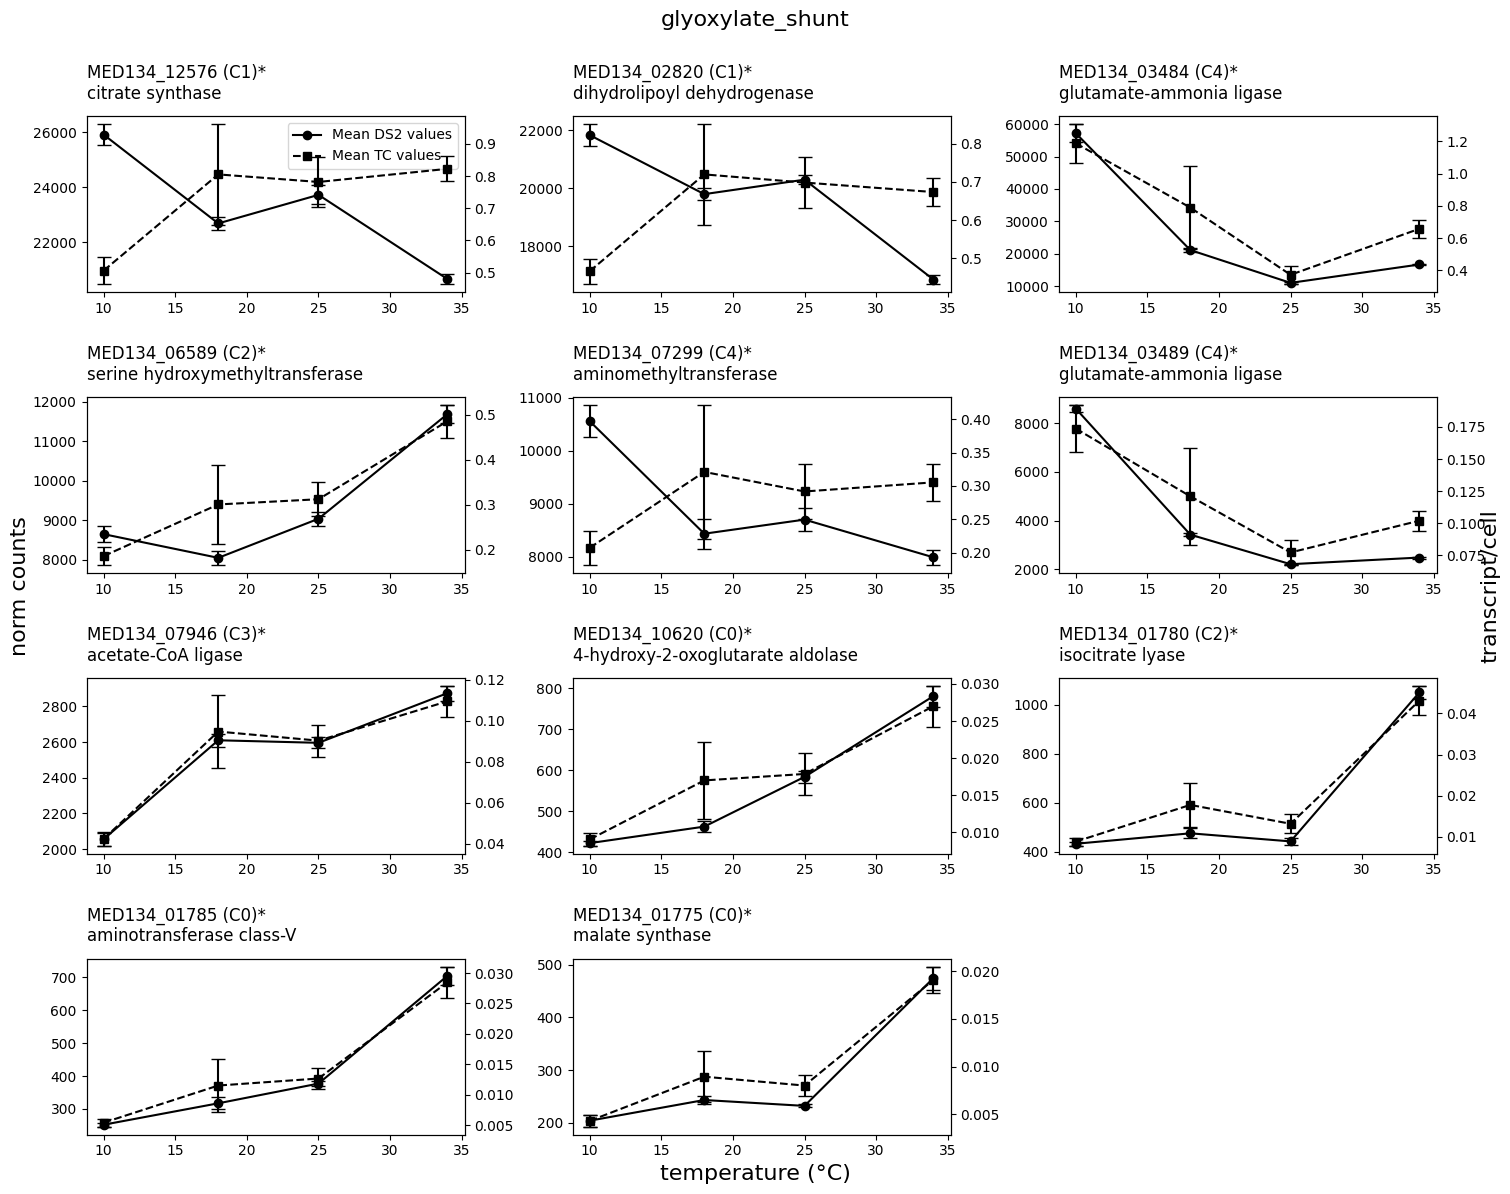

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


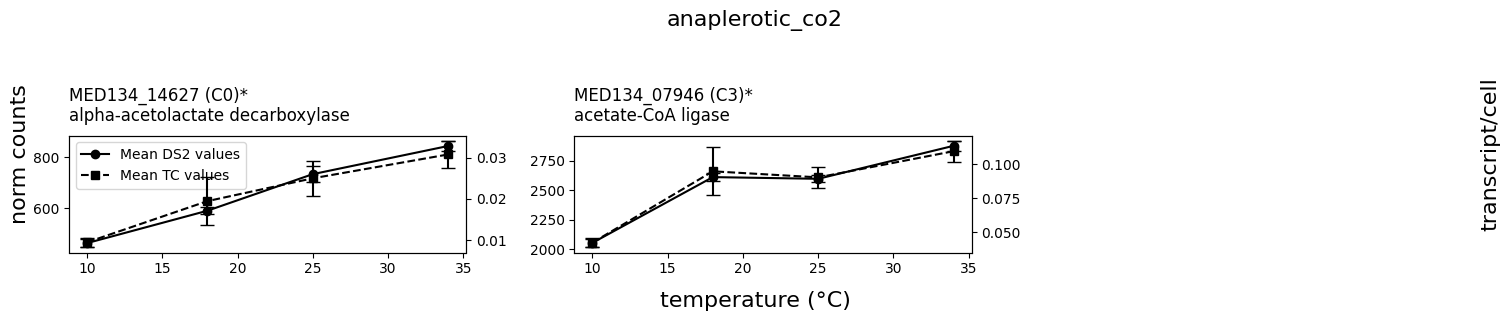

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


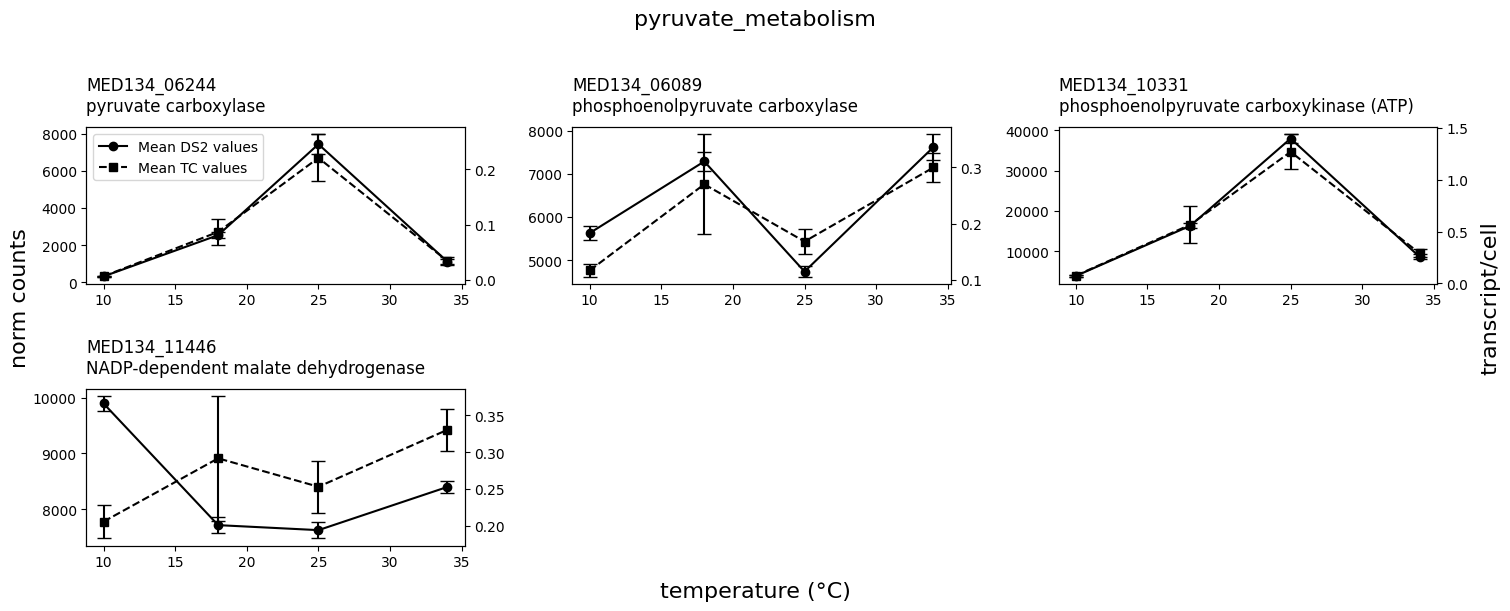

In [8]:
# Make directory for figures
(root_dir / "paper_figures/figure_5").mkdir(parents=True, exist_ok=True)

def plot_gene_expression(ax, gene_id, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    l1 = ax.plot(mean_values['Temperature'], mean_values['Value'], marker='o', linestyle='-', label='Mean DS2 values', color="k")
    ax.errorbar(mean_values['Temperature'], mean_values['Value'], yerr=standard_error_values['Value'], linestyle='', capsize=5, label='SDE DS2 values', color="k")
    ax2 = ax.twinx()
    l2 = ax2.plot(mean_values_TC['Temperature'], mean_values_TC['Value'], marker='s', linestyle='--', color='k', label='Mean TC values')
    ax2.errorbar(mean_values_TC['Temperature'], mean_values_TC['Value'], yerr=standard_error_values_TC['Value'], linestyle='', capsize=5, color='k', label='SDE TC values')

    # ax.set_xlabel('Temperature')
    # ax.set_ylabel('Mean DS2-norm Values')
    # ax2.set_ylabel('Mean TC Values')
    # ax.set_title(f'Gene: {gene_id} ({gene_name})')
    ax.set_title(f'{gene_id}\n{gene_name}', fontsize=12, loc='left', y=1.05)
    if show_legend:
        legend_handles = l1 + l2
        legend_labels = [h.get_label() for h in legend_handles]
        ax.legend(legend_handles, legend_labels)

# Code for preprocessing the primary and secondary datasets
# Replace "TC" with the name of your second dataset
marker_genes = pathway_fig_marker_genes
target_genes = [gene[0] for cluster in marker_genes.values() for gene in cluster]

ranked_clusters = pd.read_csv(results_dir / "pathways/ranked_clusters.csv", index_col=0)
deseq2_results = pd.read_excel(results_dir / "deseq_results/across_temperature_deseq2.xlsx").set_index("gene_id")

# Preprocess the primary dataset (deseq2_counts_noDE)
df_long = deseq2_counts.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

# Calculate mean and standard error values for the primary dataset (deseq2_counts_noDE)
grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the secondary dataset (TC)
TC_long = TC.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])

# Calculate mean and standard error values for the secondary dataset (TC)
grouped_TC = TC_long.groupby(['index', 'Temperature'])['Value']
mean_values_TC = grouped_TC.median().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()

for cluster, genes in marker_genes.items():
    # Plotting
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(f'{cluster}', fontsize=16)
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        mean_values_gene = mean_values[mean_values['index'] == gene_id]
        standard_error_values_gene = standard_error_values[standard_error_values['index'] == gene_id]
        mean_values_gene_TC = mean_values_TC[mean_values_TC['index'] == gene_id]
        standard_error_values_gene_TC = standard_error_values_TC[standard_error_values_TC['index'] == gene_id]
        show_legend = (idx == 0)

        gene_cluster = add_cluster_to_locus_id(ranked_clusters, gene_id)
        gene_id_str = f'{gene_id} ({gene_cluster})' if gene_cluster else gene_id
        gene_id_str = f'{gene_id_str}*' if gene_id_DE_across_temperature(gene_id, deseq2_results) else gene_id_str

        plot_gene_expression(axs[idx], gene_id_str, gene_name, mean_values_gene, standard_error_values_gene, mean_values_gene_TC, standard_error_values_gene_TC, show_legend)

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    fig.text(0.5, 0.01, 'temperature (°C)', ha='center', va='center', fontsize=16)  # x-axis label
    fig.text(0.01, 0.5, 'norm counts', ha='center', va='center', rotation='vertical', fontsize=16)  # y-axis label
    fig.text(0.99, 0.5, 'transcript/cell', ha='center', va='center', rotation='vertical', fontsize=16) 


    # plt.tight_layout()
    plt.tight_layout(pad=2, w_pad=1)
    plt.savefig(root_dir / f'paper_figures/figure_5/cluster_{cluster}_gene_expression_temperature.png')
    plt.savefig(root_dir / f'paper_figures/figure_5/cluster_{cluster}_gene_expression_temperature.eps', dpi=300)
    plt.show()

## Plot all Light / Dark DE genes

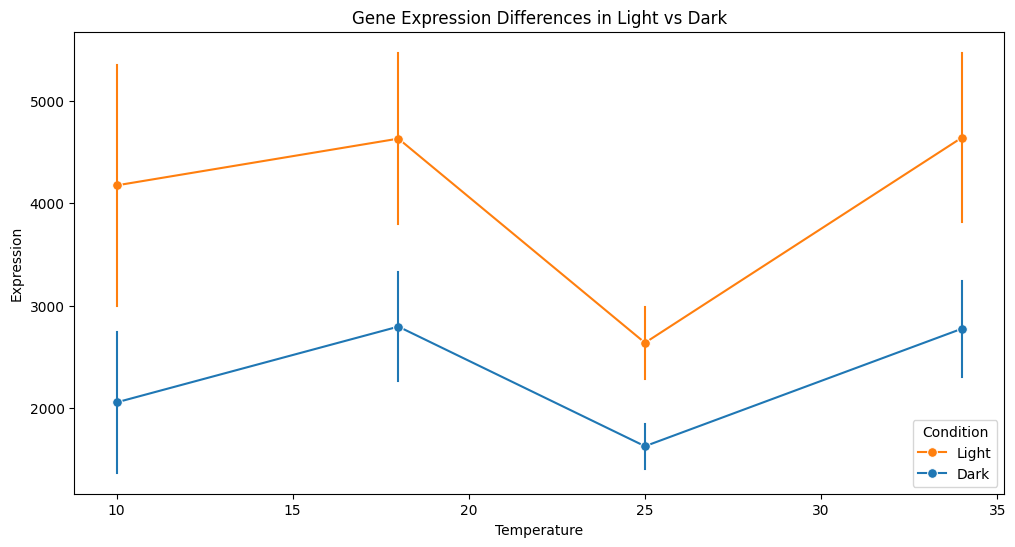

In [9]:
def process_temperature_data(temp, gene_set, deseq2_counts):
    columns_of_interest_light = [col for col in deseq2_counts.columns if f"L_{temp}_" in col]
    columns_of_interest_dark = [col for col in deseq2_counts.columns if f"D_{temp}_" in col]

    temp_data_light = deseq2_counts.loc[gene_set, columns_of_interest_light]
    temp_data_dark = deseq2_counts.loc[gene_set, columns_of_interest_dark]

    temp_data_light = temp_data_light.reset_index().melt(id_vars='gene_id', var_name='Sample', value_name='Expression')
    temp_data_light['Temperature'] = temp
    temp_data_light['Condition'] = 'Light'

    temp_data_dark = temp_data_dark.reset_index().melt(id_vars='gene_id', var_name='Sample', value_name='Expression')
    temp_data_dark['Temperature'] = temp
    temp_data_dark['Condition'] = 'Dark'

    temp_data = pd.concat([temp_data_light, temp_data_dark], axis=0)
    temp_data.rename(columns={'gene_id': 'Gene'}, inplace=True)

    return temp_data


temperatures = list(map(str, [10, 18, 25, 34]))

data = pd.concat(
    [
        process_temperature_data(temp, DELD[temp]['L>D'].index, deseq2_counts)
        for temp in temperatures
        if len(DELD[temp]['L>D']) > 0
    ],
    axis=0,
    ignore_index=True
)

data['Temperature'] = pd.to_numeric(data['Temperature'], errors='coerce')

if not data.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Temperature', y='Expression', marker='o', markersize=7, hue='Condition', data=data, errorbar='se', err_style='bars', palette=['C1', 'C0'])

    plt.xlabel('Temperature')
    plt.ylabel('Expression')
    plt.title('Gene Expression Differences in Light vs Dark')
    plt.legend(title='Condition', loc='lower right', labels=['Light', 'Dark'])

    plt.show()
else:
    print("No data to plot.")


## Plot individual plots for light/dark DE genes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


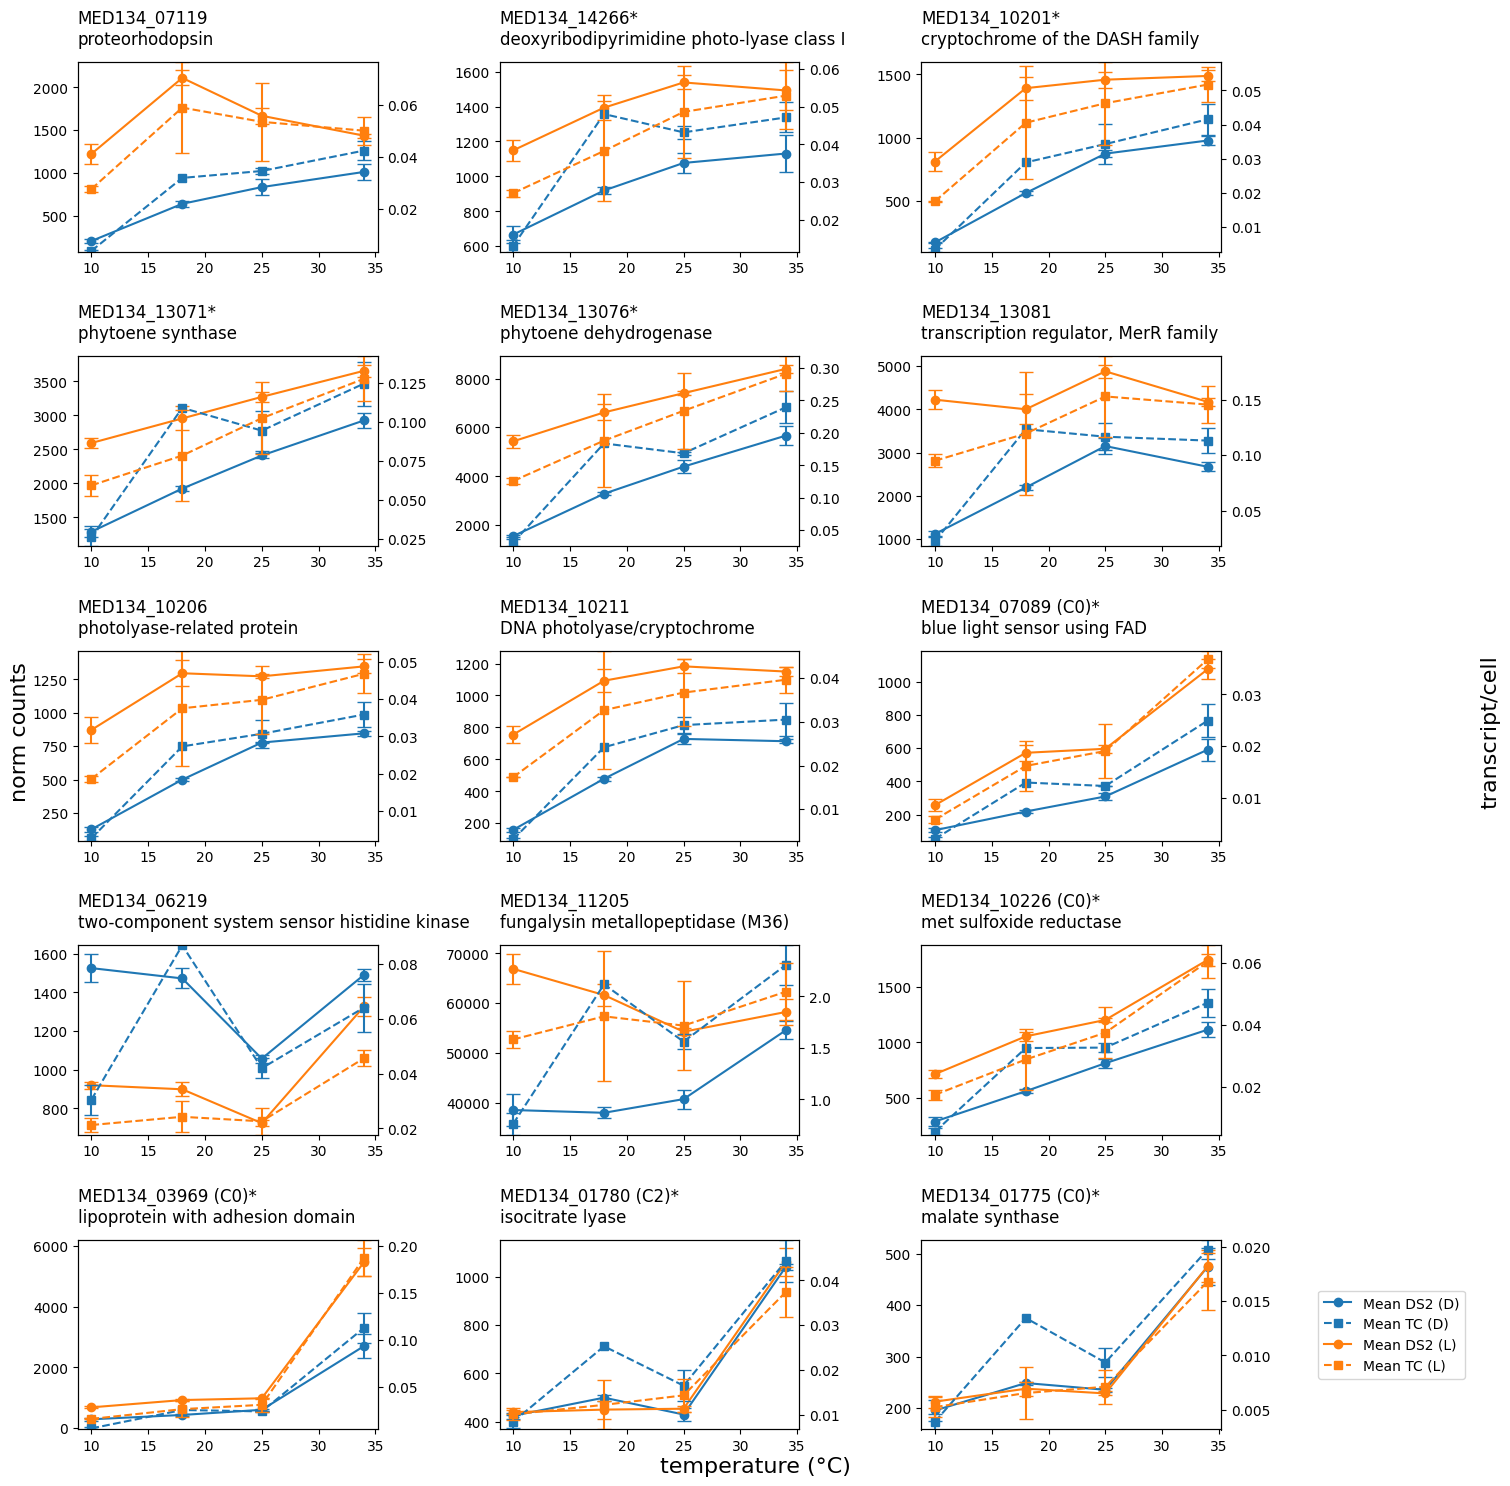

In [10]:
genes = light_marker_genes + dark_marker_genes
# target_genes = [gene[0] for gene in genes]
genes = genes + [
    ("MED134_11205", "fungalysin metallopeptidase (M36)"),
    ("MED134_10226", "met sulfoxide reductase"),
    ("MED134_03969", "lipoprotein with adhesion domain"),
    ('MED134_01780', 'isocitrate lyase'),
    ('MED134_01775', 'malate synthase')
    ]
target_genes = [gene[0] for gene in genes]


# Preprocess the new dataset (TC)
df_long = deseq2_counts.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])
df_long['Condition'] = df_long['Column'].str.extract('([LD])_')

# Calculate mean and standard error values for the new dataset (DS2)
grouped = df_long.groupby(['index', 'Temperature', 'Condition'])['Value']
# grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Load deseq LTR results and clusters
ranked_clusters = pd.read_csv(results_dir / "pathways/ranked_clusters.csv", index_col=0)
deseq2_results = pd.read_excel(results_dir / "deseq_results/across_temperature_deseq2.xlsx").set_index("gene_id")

# Preprocess the new dataset (TC)
TC_long = TC.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])
TC_long['Condition'] = TC_long['Column'].str.extract('([LD])_')

# Calculate mean and standard error values for the new dataset (TC)
grouped_TC = TC_long.groupby(['index', 'Temperature', 'Condition'])['Value']
# grouped_TC = TC_long.groupby(['index', 'Temperature'])['Value']
mean_values_TC = grouped_TC.mean().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()


def plot_gene_expression_light_dark(ax, gene_id, gene_id_str, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    conditions = ['D', 'L']
    
    # Create secondary y-axis for TC data
    ax2 = ax.twinx()

    lines = []
    labels = []

    for idx, condition in enumerate(conditions):
        mean_values_condition = mean_values[(mean_values['Condition'] == condition) & (mean_values['index'] == gene_id)]
        standard_error_values_condition = standard_error_values[(standard_error_values['Condition'] == condition) & (standard_error_values['index'] == gene_id)]
        
        line1, = ax.plot(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'],
            marker='o', linestyle='-',
            label=f'Mean DS2 ({condition})',
            color=f'C{idx}'
            )
        ax.errorbar(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'], 
            yerr=standard_error_values_condition['Value'], 
            linestyle='', capsize=5, 
            color=f'C{idx}'
            )

        mean_values_condition_TC = mean_values_TC[(mean_values_TC['Condition'] == condition) & (mean_values_TC['index'] == gene_id)]
        standard_error_values_condition_TC = standard_error_values_TC[(standard_error_values_TC['Condition'] == condition) & (standard_error_values_TC['index'] == gene_id)]

        line2, = ax2.plot(
            mean_values_condition_TC['Temperature'], 
            mean_values_condition_TC['Value'],
            marker='s', linestyle='--',
            label=f'Mean TC ({condition})',
            color=f'C{idx}'
            )
        ax2.errorbar(
            mean_values_condition_TC['Temperature'], 
            mean_values_condition_TC['Value'], 
            yerr=standard_error_values_condition_TC['Value'], 
            linestyle='', capsize=5, 
            color=f'C{idx}'
            )

        lines.append(line1)
        lines.append(line2)
        labels.append(line1.get_label())
        labels.append(line2.get_label())


    ax.set_title(f'{gene_id_str}\n{gene_name}', fontsize=12, loc='left', y=1.05)

    if show_legend:
        ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1.3, 0.5))
        
    # Automatically adjust right y-axis limits and ticks
    ax2.autoscale(axis='y', tight=True)


def plot_genes(genes, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC):
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        show_legend = (idx == len(genes) - 1)

        gene_cluster = add_cluster_to_locus_id(ranked_clusters, gene_id)
        gene_id_str = f'{gene_id} ({gene_cluster})' if gene_cluster else gene_id
        gene_id_str = f'{gene_id_str}*' if gene_id_DE_across_temperature(gene_id, deseq2_results) else gene_id_str

        plot_gene_expression_light_dark(
            axs[idx], gene_id, gene_id_str, gene_name,
            mean_values[mean_values['index'] == gene_id],
            standard_error_values[standard_error_values['index'] == gene_id],
            mean_values_TC[mean_values_TC['index'] == gene_id],
            standard_error_values_TC[standard_error_values_TC['index'] == gene_id],
            show_legend
            )

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    fig.text(0.5, 0.01, 'temperature (°C)', ha='center', va='center', fontsize=16)  # x-axis label
    fig.text(0.01, 0.5, 'norm counts', ha='center', va='center', rotation='vertical', fontsize=16)  # y-axis label
    fig.text(0.99, 0.5, 'transcript/cell', ha='center', va='center', rotation='vertical', fontsize=16) 

    plt.tight_layout(pad=2, w_pad=2)
    plt.savefig(root_dir / 'paper_figures/gene_expression_light_dark_DS2_TC.eps', format='eps', dpi=1000)
    plt.savefig(root_dir / 'paper_figures/gene_expression_light_dark_DS2_TC.png')
    plt.show()

# Call the updated plot_genes function with the new dataset (TC)
plot_genes(genes, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC)

## Same but without overlapping TC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


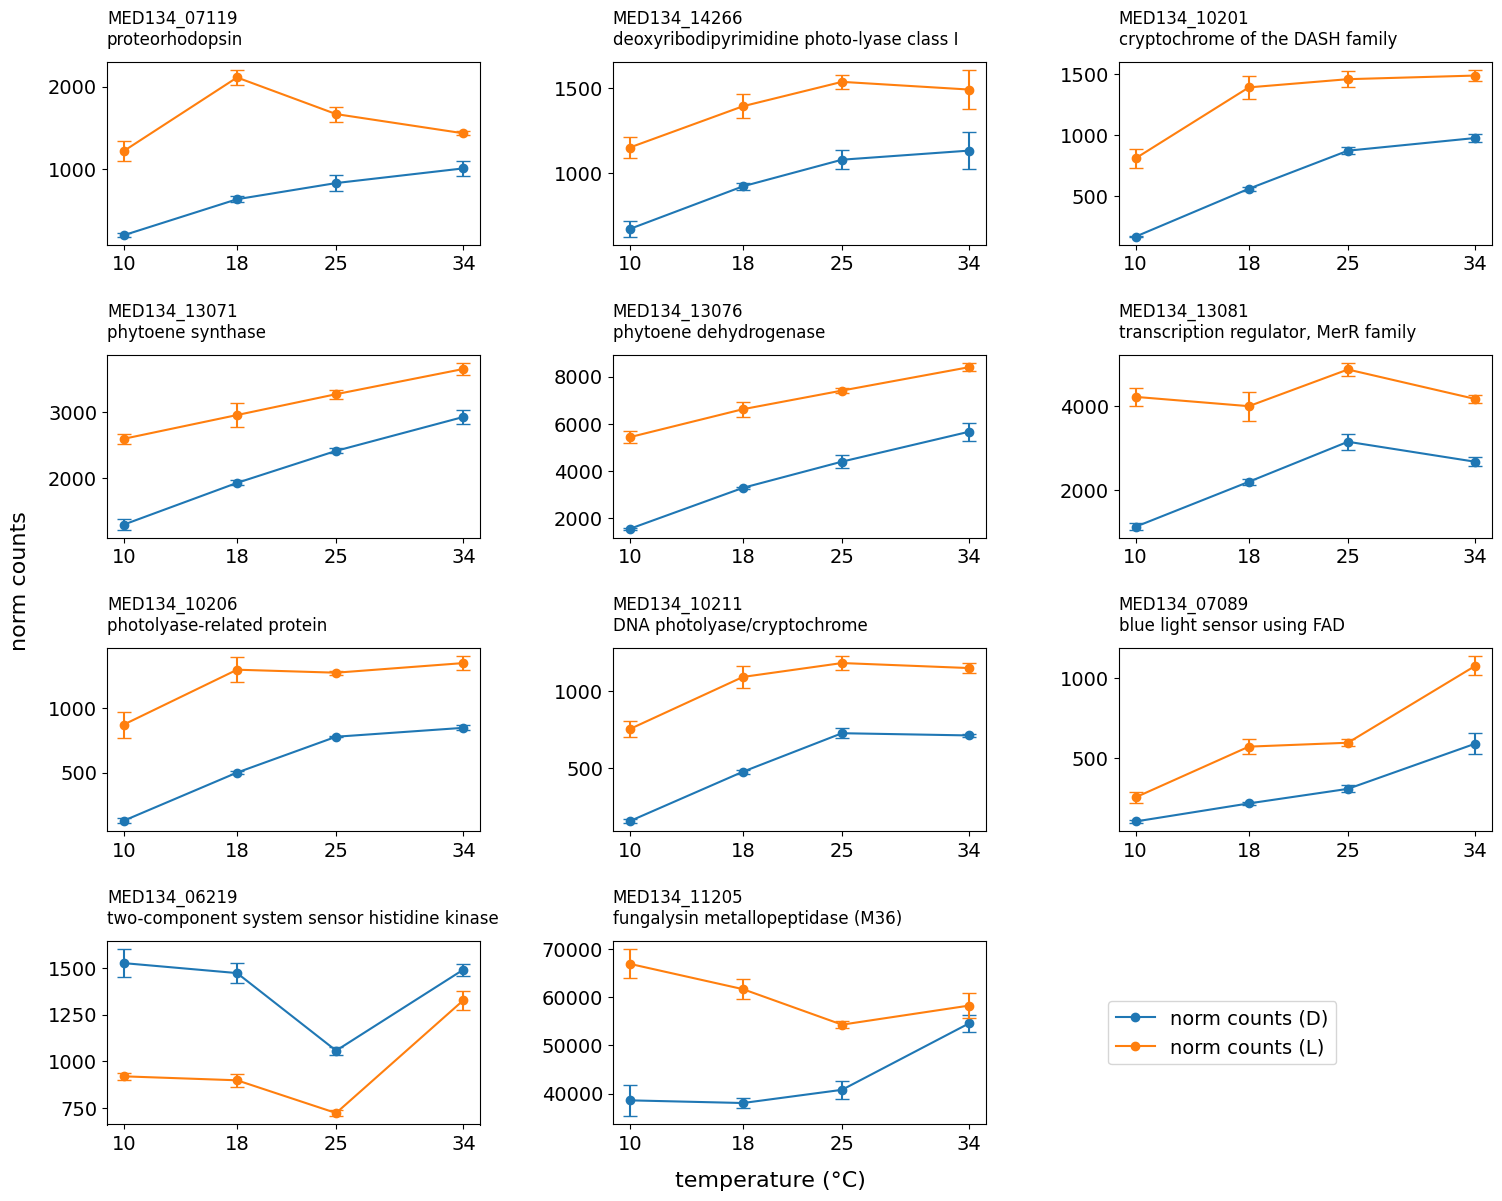

In [11]:
genes = light_marker_genes + dark_marker_genes
# target_genes = [gene[0] for gene in genes]
genes = genes + [("MED134_11205", "fungalysin metallopeptidase (M36)")]
# genes = [("MED134_11205", "fungalysin metallopeptidase (M36)")]


# Preprocess the new dataset (TC)
df_long = deseq2_counts.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])
df_long['Condition'] = df_long['Column'].str.extract('([LD])_')

# Calculate mean and standard error values for the new dataset (TC)
grouped = df_long.groupby(['index', 'Temperature', 'Condition'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()


def plot_gene_expression_light_dark(ax, gene_id, gene_name, mean_values, standard_error_values, show_legend=False):
    conditions = ['D', 'L']
    lines = []
    labels = []

    for idx, condition in enumerate(conditions):
        mean_values_condition = mean_values[(mean_values['Condition'] == condition) & (mean_values['index'] == gene_id)]
        standard_error_values_condition = standard_error_values[(standard_error_values['Condition'] == condition) & (standard_error_values['index'] == gene_id)]
        
        line1, = ax.plot(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'],
            marker='o', linestyle='-',
            label=f'norm counts ({condition})',
            color=f'C{idx}'
            )
        ax.errorbar(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'], 
            yerr=standard_error_values_condition['Value'], 
            linestyle='', capsize=5, 
            color=f'C{idx}'
            )
        lines.append(line1)
        labels.append(line1.get_label())

    ax.set_title(f'{gene_id}\n{gene_name}', fontsize=12, loc='left', y=1.05)  # increase fontsize and set title alignment to left
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticks([10, 18, 25, 34]) 

    if show_legend:
        ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=14)  # increase fontsize


def plot_genes(genes, mean_values, standard_error_values):
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        show_legend = (idx == len(genes) - 1)
        plot_gene_expression_light_dark(
            axs[idx], gene_id, gene_name,
            mean_values[mean_values['index'] == gene_id],
            standard_error_values[standard_error_values['index'] == gene_id],
            show_legend
            )

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])
    
    fig.text(0.5, 0.0, 'temperature (°C)', ha='center', va='center', fontsize=16)  # x-axis label
    fig.text(0.0, 0.5, 'norm counts', ha='center', va='center', rotation='vertical', fontsize=16)  # y-axis label

    plt.tight_layout(pad=2, w_pad=-15)
    plt.savefig(root_dir / 'paper_figures/gene_expression_light_dark.eps', format='eps', dpi=1000)
    plt.savefig(root_dir / 'paper_figures/gene_expression_light_dark.png')
    plt.show()


# Call the updated plot_genes function with the new dataset (TC)
plot_genes(genes, mean_values, standard_error_values)

Figure X: Gene expression (DeSeq2-normalized counts) of key genes in the light (orange) and dark (blue) conditions across various temperature treatments. All genes were overexpressed in the light across all temperatures (Wald test, alpha=0.01), with the exception of MED134_06219 which was overexpressed in the dark across temperatures. Lines correspond to mean values across all samples at the same tempeature, and error bars to the standard error of the mean. Genes depicted include: MED134_07119 (proteorhodopsin), MED134_14266 (deoxyribodipyrimidine photo-lyase class I), MED134_10201 (cryptochrome of the DASH family), MED134_13071 (phytoene synthase), MED134_13076 (phytoene dehydrogenase), MED134_13081 (transcription regulator, MerR family), MED134_10206 (a deoxyribodipyrimidine photolyase-related protein), MED134_10211 (DNA photolyase/cryptochrome), and MED134_07089 (blue light sensor using FAD).

## Plot DeSeq2 clusters

In [12]:
plot_cluster_data_DS2Z = read_from_pickle_file(results_dir / "clusters" / "plot_cluster_data_DS2Z.pkl")
clusters_DS2Z = read_from_pickle_file(results_dir / "clusters" / "clusters_DS2Z.pkl")

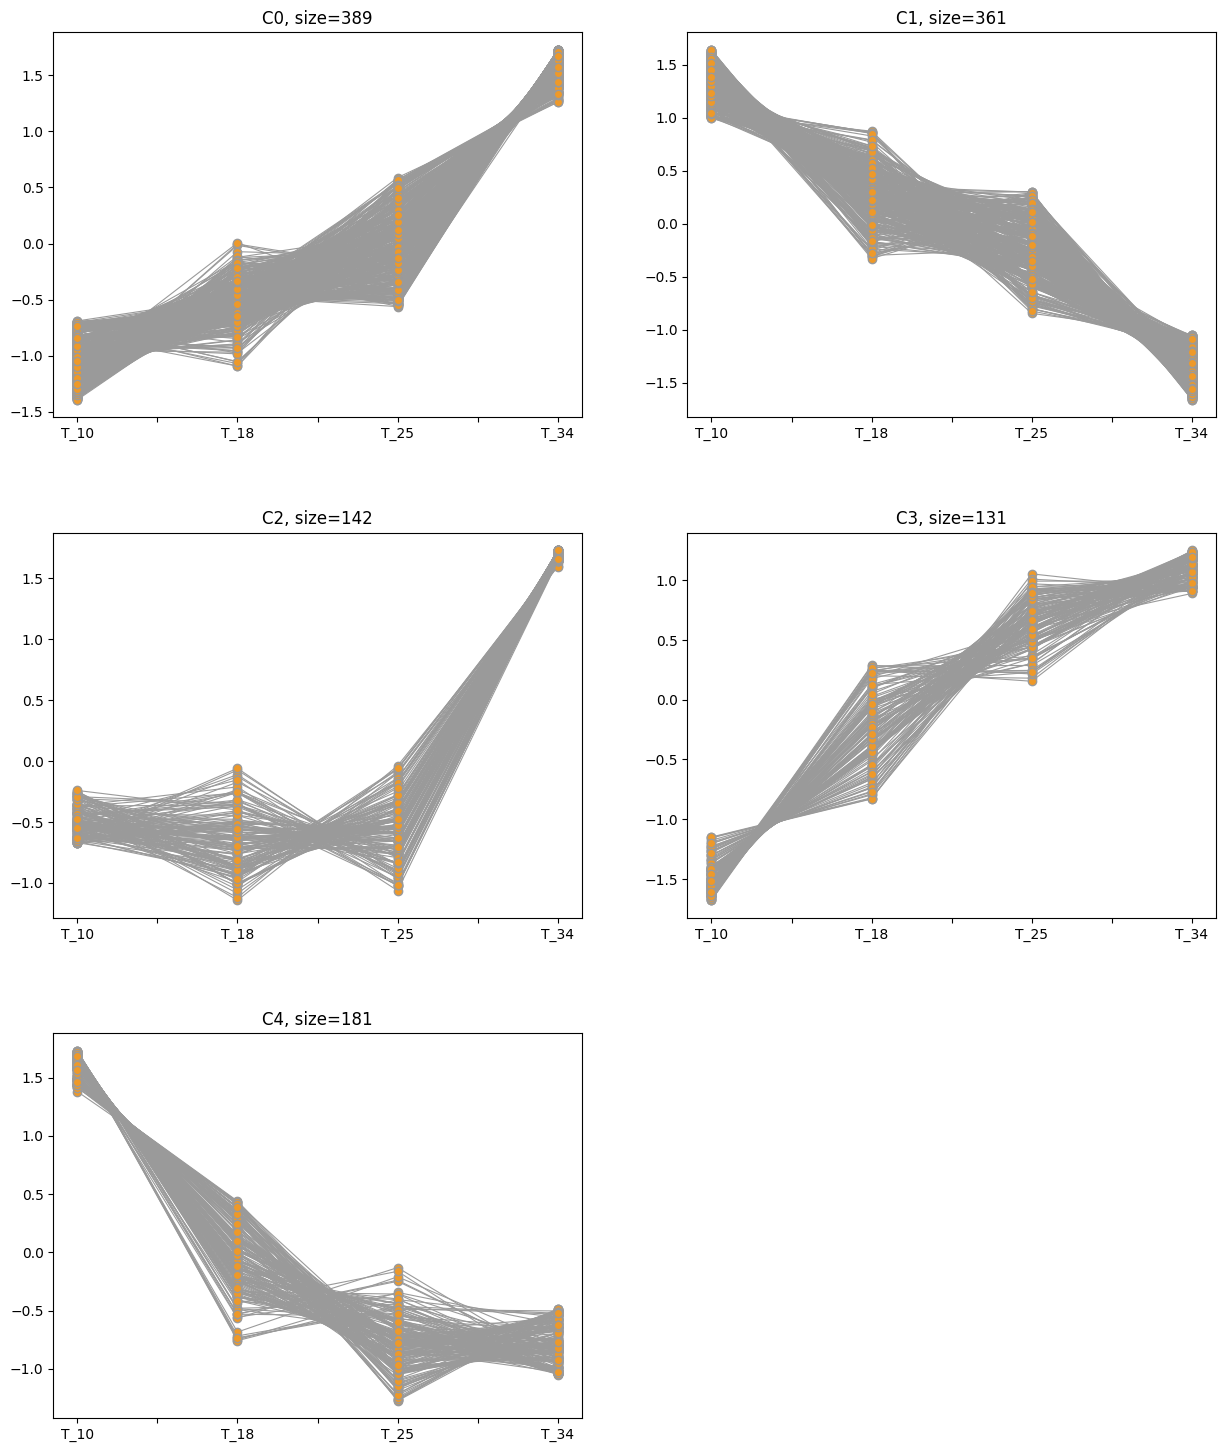

In [13]:
VI.plotClusters(
    plot_cluster_data_DS2Z, clusters_DS2Z,
    outfile=root_dir / "paper_figures/cluster_plot_DS2Z.eps",
    )

## Find strictly decreasing TC genes and corresponding DeSeq2 clusters

In [14]:
from dokdonia.utils import take_average_values, z_normalize


def get_cluster_id(clusters_DS2Z: dict, gene_name: str):
    genes_to_clusters = {gene: cluster for cluster, genes in clusters_DS2Z.items() for gene in genes}
    return genes_to_clusters.get(gene_name, 'NA')

TC_avg = take_average_values(TC, method='median')
TC_avg_Z = z_normalize(take_average_values(TC, method='median'))

group3 = TC_avg_Z[TC_avg_Z[10] > TC_avg_Z[18]]
downgenes = group3[(group3[10] > group3[18]) & (group3[18] > group3[25]) & (group3[25] > group3[34])]
downgenes.index = downgenes.index.map(lambda x: f'{x} ({get_cluster_id(clusters_DS2Z, x)})')

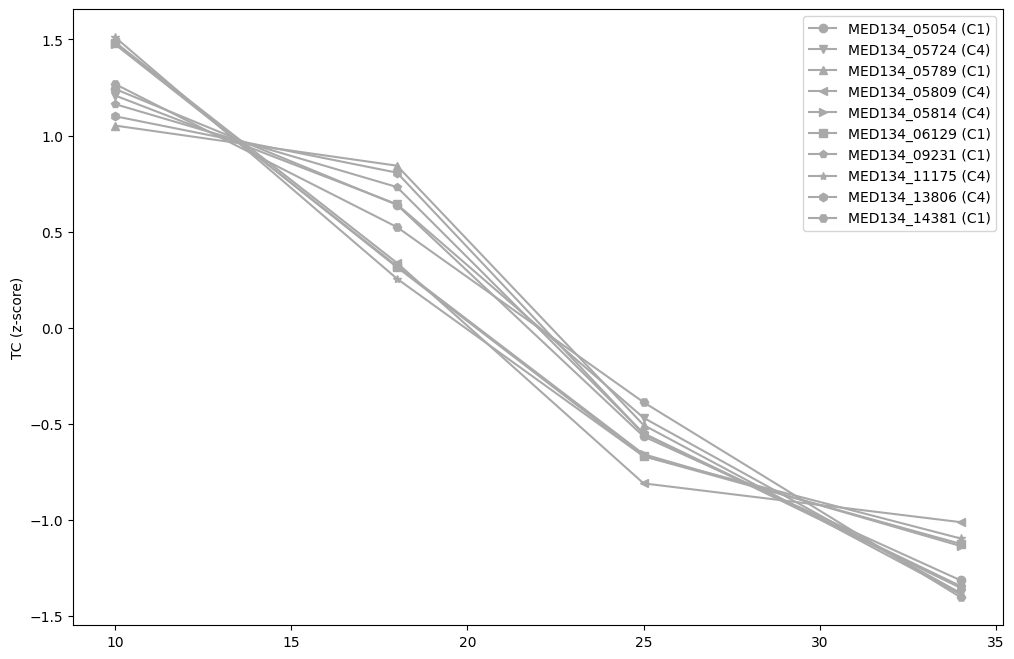

In [19]:
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
downgenes_transposed = downgenes.transpose()

fig, ax = plt.subplots(figsize=(12,8))

for i, column in enumerate(downgenes_transposed.columns):
    ax.plot(downgenes_transposed.index, downgenes_transposed[column], marker=markers[i % len(markers)], label=column, color='darkgrey')

ax.set_ylabel("TC (z-score)")
ax.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


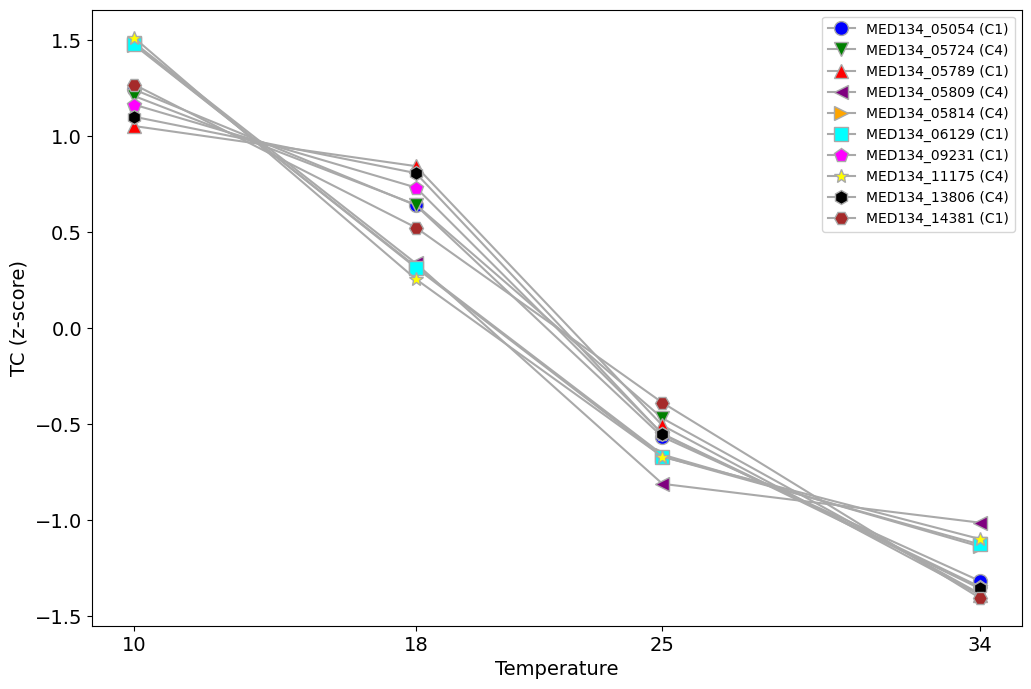

In [26]:
import matplotlib.pyplot as plt

# Your existing code
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
downgenes_transposed = downgenes.transpose()

# Define a list of colors for the markers
marker_colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'lime', 'navy', 'gray']

fig, ax = plt.subplots(figsize=(12,8))

for i, column in enumerate(downgenes_transposed.columns):
    ax.plot(downgenes_transposed.index, downgenes_transposed[column], 
            marker=markers[i % len(markers)], 
            label=column, 
            color='darkgrey',
            markersize=10,
            markerfacecolor=marker_colors[i % len(marker_colors)])  # Marker color

ax.set_xlabel("Temperature", fontsize=14)
ax.set_ylabel("TC (z-score)", fontsize=14)
desired_xticks = [10, 18, 25, 34]
ax.set_xticks(desired_xticks)
ax.set_xticklabels([str(tick) for tick in desired_xticks])
ax.tick_params(labelsize=14)
ax.legend()
fig.savefig(root_dir / "paper_figures/Figure_S2.png", dpi=300)
fig.savefig(root_dir / "paper_figures/Figure_S2.eps", dpi=300)
plt.show()

## Plot TC clusters

In [16]:
plot_cluster_data_TCZ = read_from_pickle_file(results_dir / "clusters" / "plot_cluster_data_TCZ.pkl")
clusters_TCZ = read_from_pickle_file(results_dir / "clusters" / "clusters_TCZ.pkl")

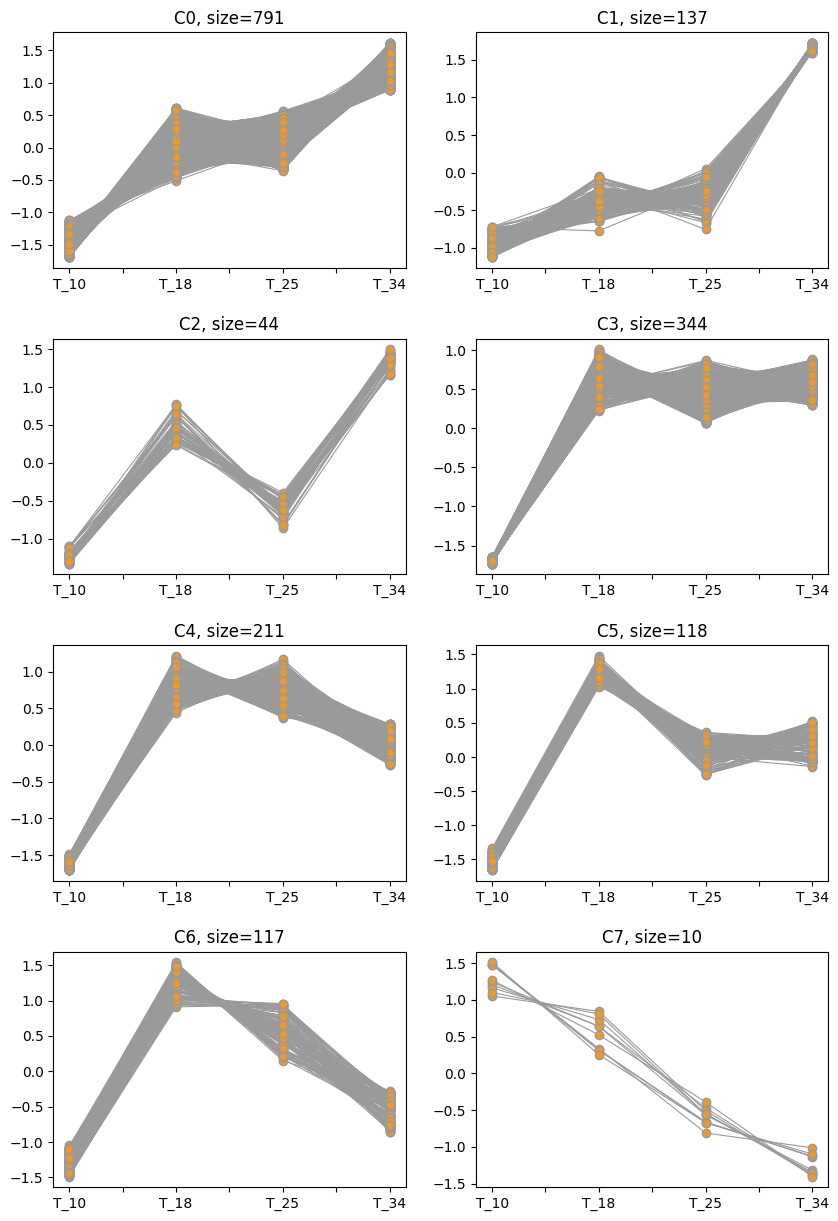

In [17]:
VI.plotClusters(
    plot_cluster_data_TCZ, clusters_TCZ,
    outfile=root_dir / 'paper_figures/cluster_plot_TCZ.png',
    figsize=(10, 15),
    )